<a href="https://colab.research.google.com/github/Aisimetra/AML-Project/blob/main/Progetto_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Advanced Machine Learning

Componenti gruppo: 
- Alice Romagnoli, matricola 829833
- Artemisia Sarteschi, matricola 829677
- Andrea Infantino, matricola 816786



L'obiettivo del progetto è quello di predire quali famiglie tra quelle descritte nel dataset hanno maggiormente bisogno di assistenza economica e sociale. 

## Librerie

Vengono caricate le librerie che verranno utilizzate in seguito.

In [ ]:
import pandas as pd
import numpy as np

#librerie per i grafici
import seaborn as sns
import matplotlib.pyplot as plt

#librerie per one hot encoding 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#librerie per famd
!pip install prince
import prince

#librerie per splittare train e test
from sklearn.model_selection import train_test_split

#librerie per il preprocessing di train e test
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

#librerie per creare la rete
import tensorflow as tf
from keras import backend as K 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.core import Activation, Flatten
from keras.layers import Activation, LeakyReLU
from tensorflow.keras.activations import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.utils import np_utils

#librerie per L1 e L2 
from tensorflow.keras import regularizers

#libreria per Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
!pip install h5py
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#librerie per class weight
from sklearn.utils import compute_class_weight

#librerie per evalution metrics
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, mean_squared_error

## Import del dataset

Viene importato il dataset "Costa Rican Household Poverty Level Prediction", presente su [Kaggle](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data).

In [ ]:
df = pd.read_csv('/content/train.csv')
print(df)

                Id      v2a1  hacdor  ...  SQBmeaned  agesq  Target
0     ID_279628684  190000.0       0  ...   100.0000   1849       4
1     ID_f29eb3ddd  135000.0       0  ...   144.0000   4489       4
2     ID_68de51c94       NaN       0  ...   121.0000   8464       4
3     ID_d671db89c  180000.0       0  ...   121.0000    289       4
4     ID_d56d6f5f5  180000.0       0  ...   121.0000   1369       4
...            ...       ...     ...  ...        ...    ...     ...
9552  ID_d45ae367d   80000.0       0  ...    68.0625   2116       2
9553  ID_c94744e07   80000.0       0  ...    68.0625      4       2
9554  ID_85fc658f8   80000.0       0  ...    68.0625   2500       2
9555  ID_ced540c61   80000.0       0  ...    68.0625    676       2
9556  ID_a38c64491   80000.0       0  ...    68.0625    441       2

[9557 rows x 143 columns]


Il dataset è composto da 9557 record per ognuno dei quali sono indicati i valori di 143 attributi.

In particolare, ogni record rappresenta una persona, appertenente a una determinata famiglia, della quale si vuole stabilire il livello di ricchezza/povertà. 

Per quanto riguarda gli attributi riportati, alcuni si riferiscono alla  singola persona, mentre altri contengono informazioni riguardanti la famiglia a cui la persona appartiene. 

In [ ]:
df.isnull().sum(axis=0)

Id                    0
v2a1               6860
hacdor                0
rooms                 0
hacapo                0
                   ... 
SQBovercrowding       0
SQBdependency         0
SQBmeaned             5
agesq                 0
Target                0
Length: 143, dtype: int64

Nel dataset risultano esserci dei missing values che dovranno essere gestiti in seguito.

In [ ]:
df.columns

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
      dtype='object', length=143)

Dal momento che le colonne del dataset hanno nomi in spagnolo e risultano essere in numero estremamente elevato, viene eseguita un'analisi delle stesse per capire il loro reale significato e la loro eventuale utilità nella predizione della variabile target.

## Analisi variabili
Per ogni variabile verrà effettuata una piccola analisi volta a capire se tenere la variabile, se il dato riportato dalla variabile viene già espresso da altre variabili e la distribuzione della variabile. 

Nel caso in cui si rivelasse utile, viene anche cambiato il nome della colonna in modo da renderlo di più facile comprensione.

#### Metodi Implementati per l'analisi delle varaibili

Il metodo `num_variable()` viene applicato per l'analisi delle variabili che contengono valori numerici, anche ordinali. 

Si occupa di cambiare i nomi delle colonne se necessario, e computa un tipo di analisi (un conteggio delle occorrenze per ogni classe o una descrizione statistica).

Infine riporta il numero di missing values riscontrati per quella variabile.

In [ ]:
def num_variable(column, mapping=None, ordinal=True): 
  if mapping != None: 
    df.rename(columns=mapping, inplace=True)
  if ordinal == True: 
    print("Categoria  Frequenza")
    print(df[column].value_counts())
  else: 
    print(df[column].describe())
  print("Numero di missing values per la variabile", column, ":", df[column].isnull().sum(axis=0))

Il metodo `plot_num_variable()` serve per visualizzare la distribuzione di una variabile con valori numerici. 

I parametri `many_values` e `nonzero` permettono di modificare alcune impostazioni del grafico, in particolare `many_values == True` adatta il grafico ad avere molti valori sull'asse x, mentre `nonzero == True` adatta il grafico al fatto che il valore 0 non viene mai assunto da nessun record.

In [ ]:
def plot_num_variable(column, xlabel, many_values = False, nonzero = False): 
  if many_values == True: 
    sns.histplot(df[column], element="bars", kde=True, color="darkgreen")  
  else: 
    sns.histplot(df[column], element="bars", binwidth=1, color="darkgreen", discrete=True)
    if nonzero == True:
      plt.xticks(ticks=range(len(df[column].unique())+1))
    else: 
      plt.xticks(ticks=range(len(df[column].unique())))

  plt.title('Distribuzione della variabile ' + column)
  plt.xlabel(xlabel)
  plt.ylabel('Frequenza')

Il metodo `single_column()` serve per passare da una rappresentazione one hot encode di più colonne a una sola colonna contenente come valori i nomi delle colonne.

In [ ]:
def single_column(df): 
  return (df[df.columns]*df.columns).sum(axis=1)

Il metodo `cat_variable()` si occupa delle variabili cateriche che siano o binarie o abbiano stringhe come valori.

Innnanzitutto, si occupa di cambiare i nomi delle colonne se necessario, e chiama `single_column()`, se necessario, per racchiudere l'informazione in un'unica nuova variabile.

Dopodiché riporta un conteggio delle occorrenze per ogni classe e il numero di missing values riscontrati per quella variabile.

In [ ]:
def cat_variable(newcolumn, mapping=None, classes = None): 
  if mapping != None: 
    df.rename(columns=mapping, inplace=True)
    
  if classes != None: 
    df[newcolumn] = ""
    df[newcolumn] = single_column(df[classes])
    df.drop(classes, inplace=True, axis=1)

  print(df[newcolumn].value_counts())
  print("Numero di missing values per la variabile", newcolumn, ":", df[newcolumn].isnull().sum(axis=0))

Il metodo `plot_cat_variable()` serve per visualizzare la distribuzione di una variabile binaria o con valori sotto forma di stringhe.

Il parametro `binary` serve quindi a differenziare questi due tipi di variabili e a impiegare il giusto grafico. 

`central` viene invece adoperato per una questione di leggibilità delle label nel grafico.

In [ ]:
def plot_cat_variable(newcolumn, xlabel="Tipologia", binary=True, central=True):
    if binary == True: 
      sns.histplot(data=df, x=newcolumn, binwidth=1, discrete=True, hue=newcolumn, legend=False)
      plt.xticks(ticks=[1.0, 0.0], labels=["True", "False"])
    else:
      if len(df[newcolumn].unique()) < 5: 
        sns.catplot(data=df, x=newcolumn, kind='count', order=df[newcolumn].value_counts().index, palette=sns.color_palette("husl", 9))
      elif central == True:
        sns.catplot(data=df, x=newcolumn, kind='count', order=df[newcolumn].value_counts().index, palette=sns.color_palette("husl", 9))
        plt.xticks(rotation=30, ha="center")
      else: 
        sns.catplot(data=df, x=newcolumn, kind='count', order=df[newcolumn].value_counts().index, palette=sns.color_palette("husl", 9))
        plt.xticks(rotation=40, ha="right")
     

    plt.title('Distribuzione della variabile ' + newcolumn)
    plt.xlabel(xlabel)
    plt.ylabel('Frequenza')

#### Variabile `idhogar` (`id_family`)

Questa variabile riporta, per ogni individuo, l'identificativo della propria famiglia.

In [ ]:
cat_variable(mapping = {'idhogar': 'id_family'}, newcolumn = "id_family")

fd8a6d014    13
0c7436de6    12
ae6cf0558    12
3fe29a56b    11
6b35cdcf0    11
             ..
850aca0fa     1
fe30320e4     1
824a38567     1
7fc5dc154     1
a46d8862c     1
Name: id_family, Length: 2988, dtype: int64
Numero di missing values per la variabile id_family : 0


In [ ]:
df['id_family'].nunique()

2988

Nel dataset sono presenti quasi 3000 famiglie e il numero di persone in esse va da 1 a 13.

Text(0, 0.5, 'Frequenza')

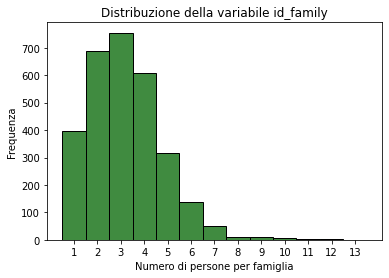

In [ ]:
sns.histplot(df["id_family"].value_counts().values, element="bars", binwidth=1, color="darkgreen", discrete=True)
plt.xticks(ticks=range(1, 14))
plt.title('Distribuzione della variabile id_family')
plt.xlabel('Numero di persone per famiglia')
plt.ylabel('Frequenza')

Come possiamo notare dal grafico, la stragrande maggioranza delle famiglie comprende dagli 1 ai 5 componenti e relativamente poche famiglie hanno un numero maggiore di componenti. 




Per semplicificare l'analisi di tante variabili si è deciso di dividerle in categorie per poter avere un'idea più chiara del tipo di informazione contenuto nel dataset.

Di seguito quindi verranno presentate variabili numeriche, ordinali, binarie e categoriche (contenenti stringhe).

### Variabili numeriche


#### Variabile `v2a1` (`monthly_rent_payment`)
Questa variabile rappresenta l'ammontare dell'affitto mensile per ogni famiglia.

In [ ]:
num_variable(column = "monthly_rent_payment", mapping = {'v2a1': 'monthly_rent_payment'}, ordinal=False)

count    2.697000e+03
mean     1.652316e+05
std      1.504571e+05
min      0.000000e+00
25%      8.000000e+04
50%      1.300000e+05
75%      2.000000e+05
max      2.353477e+06
Name: monthly_rent_payment, dtype: float64
Numero di missing values per la variabile monthly_rent_payment : 6860


Come è possibile notare da una semplice analisi, il valore minimo assunto dalla variabile è zero, quindi ci sono persone che non hanno un affitto da pagare. 

Un'altra cosa che è possibile notare è la presenza di moltissimi missing values, quasi 7000. 

Questo aspetto verrà analizzato più avanti utilizzando anche i valori di `type_of_contract`. 

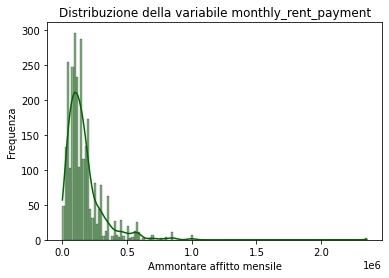

In [ ]:
plot_num_variable(column="monthly_rent_payment", xlabel='Ammontare affitto mensile', many_values=True)

La distribuzione della variabile risulta avere un andamento più o meno normale ma schiacciato verso i valori più bassi assunti dalla variabile. Risulta essere raro quindi che una famiglia paghi un affitto mensile tra i più alti.

### Variabili ordinali

Per variabili ordinali abbiamo inteso tutte quelle variabili con valori numerici che sottointendono un ordinamento. 

Di seguito vengono quindi prima analizzate le variabili relative alle singole persone e successivamente quelle relative alle intere famiglie.

#### Variabile `age`

Questa variabile rappresenta l'età di ogni individuo.

In [ ]:
num_variable(column = "age", ordinal=False)

count    9557.000000
mean       34.303547
std        21.612261
min         0.000000
25%        17.000000
50%        31.000000
75%        51.000000
max        97.000000
Name: age, dtype: float64
Numero di missing values per la variabile age : 0


Possiamo notare come l'età degli individui vada da 0 a 97 e mediamente sia di 34 anni. 

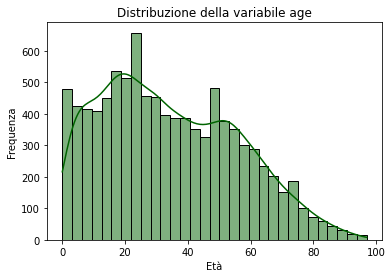

In [ ]:
plot_num_variable(column="age", xlabel='Età', many_values=True)

Come è possibile vedere dal grafico, la maggior parte delle persone (75%) ha meno di 51 anni. 
Inoltre, l'andamento ha un picco tra i 20 e i 30 anni, mentre all'aumentare dell'età (dai 50 anni in poi) progressivamente diminuisce il numero di persone nel dataset con quell'età.

#### Variabile `escolari` (`education_years`) 

Questa variabile rappresenta il numero di anni di istruzione conseguiti da ogni individuo.

In [ ]:
num_variable(column = "education_years", mapping = {"escolari" : "education_years"}, ordinal=False)

count    9557.000000
mean        7.200272
std         4.730877
min         0.000000
25%         4.000000
50%         6.000000
75%        11.000000
max        21.000000
Name: education_years, dtype: float64
Numero di missing values per la variabile education_years : 0


Gli individui presenti nel dataset riportano dagli 0 ai 21 anni di istruzione, con una media di 7.

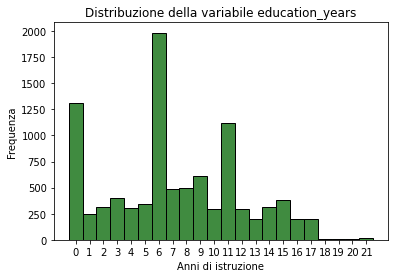

In [ ]:
plot_num_variable(column="education_years", xlabel='Anni di istruzione')

Quello che si nota dalla distribuzione è che per la maggior parte degli anni si ha una frequenza uniforme, ma 0, 6 e 11 presentano tre picchi di occorrenze. 

Questo fa pensare che la maggior parte delle persone o non ha istruzione o ha terminato un ciclo di studi di 6 anni o di 11; gli altri probabilmente sono individui che hanno intrapreso cicli di studi meno comuni oppure non l'hanno portato a termine.

Analizziamo ora l'altra variabile relativa all'istruzione, `rez_esc`, che riporta il numero di anni scolastici indietro per ogni persona.

In [ ]:
print("Numero di missing values per la variabile", "rex_esc", ":", df["rez_esc"].isnull().sum(axis=0))
df.drop("rez_esc", inplace=True, axis=1)

Numero di missing values per la variabile rex_esc : 7928


Dal momento che `rez_esc` presenta un così alto numero di missing values, è stato deciso di rimuovera dal dataset.

La variabile `meaneduc` invece, che rappresenta il numero medio di anni di istruzione degli adulti della famiglia, è stata rimossa in quanto questa informazione è ricavabile dalle altre variabili del dataset.

In [ ]:
df.drop("meaneduc", inplace=True, axis=1)

Le seguenti variabili si riferiscono invece a informazioni che riguardano la famiglia dell'individuo.

#### Variabili `hogar_nin`, `hogar_adul`, `hogar_mayor` (`num_children` `num_adults` `num_elderly`)

Le seguenti variabili riportano il numero di persone all'interno della famiglia, in particolare, il numero di bambini (<19 anni), il numero di adulti e il numero di anziani (>65 anni). 

In [ ]:
num_variable(column = "num_children", mapping = {'hogar_nin': 'num_children'}, ordinal=False)

count    9557.000000
mean        1.406613
std         1.366185
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: num_children, dtype: float64
Numero di missing values per la variabile num_children : 0


Le famiglie considerate hanno mediamente 1/2 bambini, con un minimo di 0 e un massimo di 9.

Rimangono comunque molto poche le famiglie con più di 2 bambini, infatti il 75% delle famiglie ha meno di 3 figli.

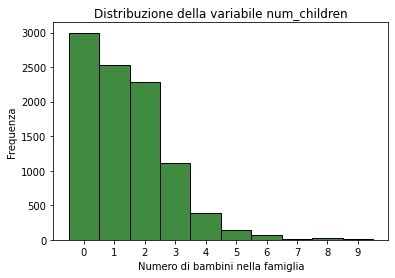

In [ ]:
plot_num_variable(column="num_children", xlabel="Numero di bambini nella famiglia") 

La variabile `num_children` presenta un'andamento di discesa da numeri di bambini minori a numeri maggiori.

In [ ]:
num_variable(column = "num_adults", mapping = {'hogar_adul': 'num_adults'}, ordinal=False)

count    9557.000000
mean        2.592445
std         1.166074
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: num_adults, dtype: float64
Numero di missing values per la variabile num_adults : 0


Le famiglie considerate presentano mediamente 2/3 adulti, con un minimo di 0 e un massimo di 9. 

Rimangono comunque rare le famiglie con molti adulti, infatti il 75% delle famiglie presenta meno di 4 adulti.

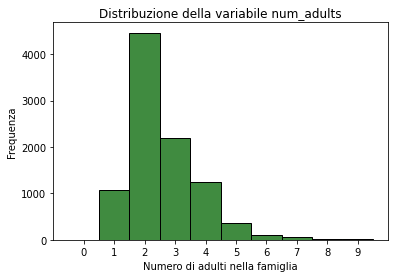

In [ ]:
plot_num_variable(column="num_adults", xlabel="Numero di adulti nella famiglia") 

La variabile `num_adults` segue un andamento simil gaussiano, con un picco in 2. 

Le famiglie con 2 adulti risultano quindi essere le più frequenti, mentre quelle con molti adulti o con nessuno, molto rare.

In [ ]:
num_variable(column = "num_elderly", mapping = {'hogar_mayor': 'num_elderly'}, ordinal=False)

count    9557.000000
mean        0.284085
std         0.597163
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: num_elderly, dtype: float64
Numero di missing values per la variabile num_elderly : 0


Per quanto riguarda il numero di anziani per ogni famiglia, notiamo che tendenzialmente sono 0 (almeno per il 75% delle famiglie) e arrivano al massimo a 3 per famiglia.

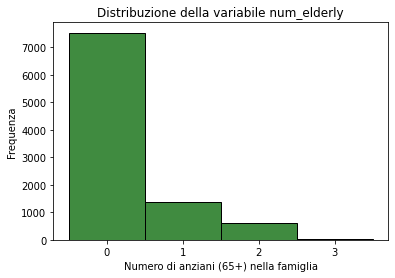

In [ ]:
plot_num_variable(column="num_elderly", xlabel="Numero di anziani (65+) nella famiglia") 

La distribuzione della variabile rispecchia il fatto che la stragrande maggioranza delle famiglie non hanno individui anziani, poche famiglie ne hanno uno, ancora meno due e un numero quasi trascurabile ne ha 3.

La combinazione di queste 3 variabili consente di ottenere l'informazione riguardante il numero totale di persone presenti in ogni famiglia.

#### Variabili `r4t3`, `tamhog`, `tamviv`, `hhsize`, `hogar_total`

Queste variabili riportano l'indicazione del numero di persone presenti all'interno di ogni famiglia. 

Essendo che questa informazione può già essere ricavata dalle variabili `num_children`, `num_adults` e `num_elderly`, si è decido di rimuovere queste colonne.

In [ ]:
df.drop(["r4t3", "tamhog", "tamviv", "hhsize", "hogar_total"], inplace=True, axis=1)

Per lo stesso motivo, viene rimossa anche `dependency`, ovvero il rapporto tra il numero di bambini o anziani e il numero di adulti per famiglia.

In [ ]:
df.drop(["dependency"], inplace=True, axis=1)

#### Variabili `rooms`, `bedrooms`
Queste due variabili riportano rispettivamente il numero di stanze e camere da letto presenti nella casa di ogni famiglia.

In [ ]:
num_variable(column = "rooms", ordinal=False)

count    9557.000000
mean        4.955530
std         1.468381
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        11.000000
Name: rooms, dtype: float64
Numero di missing values per la variabile rooms : 0


Mediamente ogni persona dispone di 5 stanze nella propria casa, andando da un minimo di una a un massimo di 11.

In generale il 75% delle persone vive in una casa con meno di 7 stanze. 

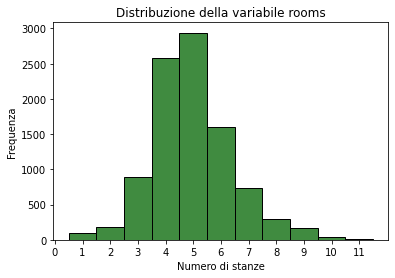

In [ ]:
plot_num_variable(column="rooms", xlabel="Numero di stanze", nonzero=True) 

La distribuzione della variabile `room` assume un andamento gaussiano con un picco in 5. 

In [ ]:
num_variable(column = "bedrooms", ordinal=False)

count    9557.000000
mean        2.739981
std         0.944507
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: bedrooms, dtype: float64
Numero di missing values per la variabile bedrooms : 0


Mediamente ogni persona vive in una casa con 2/3 camere da letto, andando da un minimo di 1 a un massimo di 8. 

Almeno il 75% delle persone abita comunque in una casa con non più di 3 camere da letto.

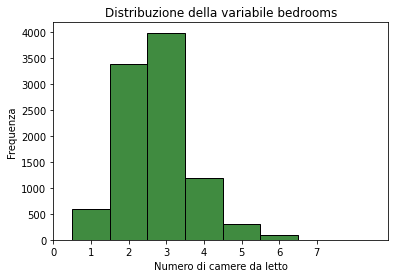

In [ ]:
plot_num_variable(column="bedrooms", xlabel="Numero di camere da letto", nonzero=True) 

Anche per le camere da letto la distribuzione risulta essere gaussiana con un picco in 3.

L'informazione del numero di persone in ogni famiglia congiunta con il numero di stanze e camere da letto a disposizione, rende superflue le seguenti variabili, che sono pertanto state rimosse: 
- `overcrowding`: number of people per room.
- `hacdor`: presence of overcrowding referring to the number of bedrooms.
- `hacapo`: presence of overcrowding referring to the number of rooms.

In [ ]:
df.drop(["overcrowding", "hacdor", "hacapo"], inplace=True, axis=1)

#### Variabili `r4m3` and `r4h3` (`tot_females` and `tot_males`)

Queste due variabili riportano rispettivamente il numero di donne e di uomini all'interno della famiglia.

In [ ]:
num_variable(column="tot_females", mapping={"r4m3" : "tot_females"}, ordinal=False)

count    9557.000000
mean        2.060898
std         1.206172
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: tot_females, dtype: float64
Numero di missing values per la variabile tot_females : 0


Mediamente, in ogni famiglia ci sono 2 donne, fino a un massimo di 8. 
In prevalenza comunque nelle famiglie ci sono una o due donne.

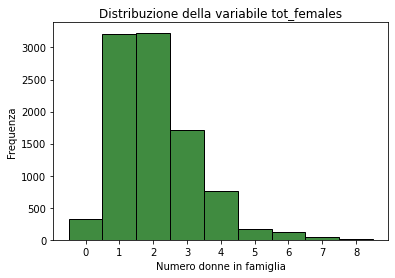

In [ ]:
plot_num_variable(column="tot_females", xlabel="Numero donne in famiglia") 

In [ ]:
num_variable(column="tot_males", mapping={"r4h3" : "tot_males"}, ordinal=False)

count    9557.000000
mean        1.945066
std         1.188852
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: tot_males, dtype: float64
Numero di missing values per la variabile tot_males : 0


Mediamente, in ogni famiglia ci sono 2 uomini, fino a un massimo di 8. 
In prevalenza comunque nelle famiglie ci sono una o due uomini.

la distribuzione tra donne e uomini è molto simile.

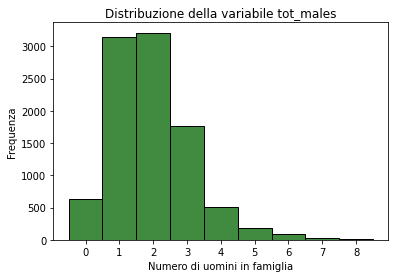

In [ ]:
plot_num_variable(column="tot_males", xlabel="Numero di uomini in famiglia") 

Vengono rimosse le variabili relative al numero di bambine/bambini con età inferiore ai 12 anni, il numero di donne/uomini con età maggiore di 12 anni, il numero totale di bambini con meno di 12 anni e di persone con più di 12 anni. 

Tutte queste variabili infatti riportano informazioni ottenibili dalla combinazione di altre variabili già presenti nel dataset.

In [ ]:
df.drop(["r4h1", "r4h2", "r4m1", "r4m2", "r4t1", "r4t2"], inplace=True, axis=1)

#### Variabile `v18q1` (`num_tablets`)

Questa variabile indica il numero di tablet posseduti dalla famiglia dell'individuo.

In [ ]:
num_variable(column = "num_tablets", mapping = {"v18q1" : "num_tablets"})

Categoria  Frequenza
1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: num_tablets, dtype: int64
Numero di missing values per la variabile num_tablets : 7342


Per la variabile `num_tablets` è presente un numero estremamente elevato di missing values (più di 7000). 

Notando però la distribuzione dei valori che assume, è sembrato ragionevole pensare che in realtà i missing values si riferiscano semplicmente ai casi in cui la famiglia dell'individuo non possieda nessun tablet. Questa considerazione viene confermata anche dalla variabile `has_tablet`.

I missing values sono pertanto stati posti a zero.

In [ ]:
df["num_tablets"] = df["num_tablets"].fillna(0)
print(df["num_tablets"].describe())
print("Numero di missing values per la variabile num_tablets:", df["num_tablets"].isnull().sum(axis=0))

count    9557.000000
mean        0.325416
std         0.697118
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: num_tablets, dtype: float64
Numero di missing values per la variabile num_tablets: 0


Come si può notare, la stragrande maggioranza delle persone non ha tablet in famiglia, ma alcune famiglie arrivano ad averne addirittura 6.

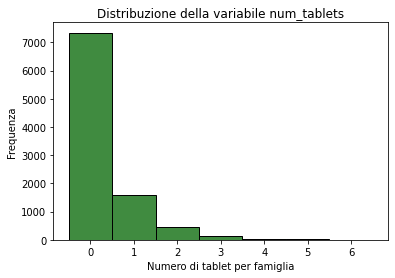

In [ ]:
plot_num_variable(column="num_tablets", xlabel="Numero di tablet per famiglia") 

#### Variabile `qmobilephone` (`num_phones`)

Questa variabile rappresenta il numero di telefoni posseduti in famiglia.

In [ ]:
num_variable(column = "num_phones", mapping = {"qmobilephone" : "num_phones"}, ordinal=False)

count    9557.000000
mean        2.821492
std         1.483249
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: num_phones, dtype: float64
Numero di missing values per la variabile num_phones : 0


Come si può notare, il numero di telefoni per famiglia va da un minimo di 1 a un massimo di 10, ma mediamente ogni famiglia possiede 2/3 telefoni.

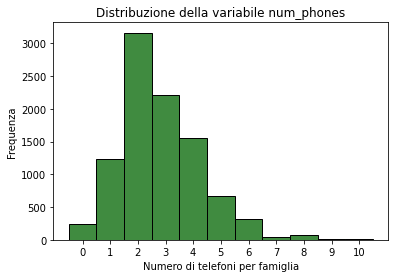

In [ ]:
plot_num_variable(column="num_phones", xlabel="Numero di telefoni per famiglia") 

La distribuzione di `num_phones` è una gaussiana con picco in 2.

#### Variabili `edjefe`, `edjefa` (`household_head_education`) 

La variabile `household_head_education` rappresenta il numero di anni di istruzione del capofamiglia ed è stata ricavata dall'unione di due variabili, che differenziavano capifamiglia donne da capifamiglia uomini. Si è deciso di unificare l'informazione in un'unica variabile.

Questa variabile riportava valori numerici (il numero di anni) ma anche la stringa "no" per rappresentare il fatto che il capofamiglia non avesse alcuna istruzione e la stringa "yes" per rappresentare il fatto che il capofamiglia avesse un solo anno di istruzione. 

Al fine di uniformare la rappresentazione dei valori per questa variabile i "no" sono stati convertiti in 0 e gli "yes" in 1. 

In [ ]:
#sostituzione dei no in 0 e degli yes in 1
df['edjefe']=df['edjefe'].replace('no',0)
df['edjefa']=df['edjefa'].replace('no',0)
df['edjefe']=df['edjefe'].replace('yes',1)
df['edjefa']=df['edjefa'].replace('yes',1)

In [ ]:
#unione di edjefe e edjefa in un'unica variabile, household_head_education
newcolumn = "household_head_education"
df[newcolumn] = df['edjefe']
for i in range(0, df.shape[0]):
  if (df[newcolumn][i] == 0):
    df[newcolumn][i] == df['edjefa'][i]

In [ ]:
df["household_head_education"] = df["household_head_education"].astype("int64")

In [ ]:
num_variable(column=newcolumn, mapping=None, ordinal=False)

count    9557.000000
mean        5.096788
std         5.246513
min         0.000000
25%         0.000000
50%         6.000000
75%         9.000000
max        21.000000
Name: household_head_education, dtype: float64
Numero di missing values per la variabile household_head_education : 0


I valori assumibili da questa variabile sono compresi tra 0 e 21, ma il 75% dei capifamiglia non ha conseguito più di 9 anni di studio. 
Mediamente i capifamiglia studiano per 5 anni.

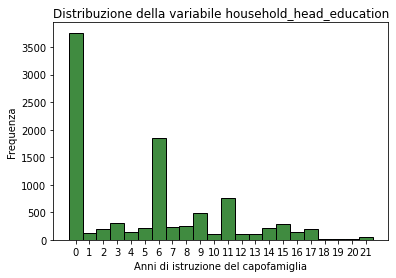

In [ ]:
plot_num_variable(column="household_head_education", xlabel="Anni di istruzione del capofamiglia") 

La distribuzione riporta un picco in 0 (moltissimi capifamiglia non hanno studiato) e un secondo in 6 (una buona porzione di capifamiglia ha studiato per 6 anni).

In [ ]:
df.drop(["edjefa", "edjefe"], inplace=True, axis=1)

### Variabili binarie

Di seguito vengono analizzate le variabili binarie con valori 0 e 1. 

#### Variabile `v14a` (`has_bathroom`)
Questa variabile rappresenta la presenza o meno del bagno all'interno della casa dell'individuo considerato.

In [ ]:
cat_variable(mapping = {'v14a': 'has_bathroom'}, newcolumn = "has_bathroom")

1    9507
0      50
Name: has_bathroom, dtype: int64
Numero di missing values per la variabile has_bathroom : 0


La stragrande maggioranza delle persone possiede il bagno in casa. 

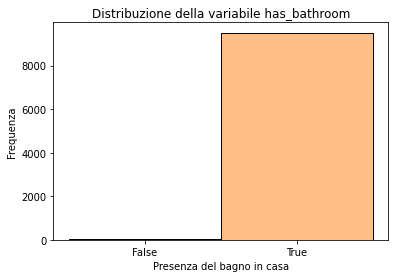

In [ ]:
plot_cat_variable(newcolumn="has_bathroom", xlabel="Presenza del bagno in casa", binary=True)

#### Variabile `refrig` (`has_refrigerator`)

Questa variabile indica la presenza o meno del frigorifero in casa dell'individuo considerato.

In [ ]:
cat_variable(mapping = {'refrig': 'has_refrigerator'}, newcolumn = "has_refrigerator")

1    9152
0     405
Name: has_refrigerator, dtype: int64
Numero di missing values per la variabile has_refrigerator : 0


La maggior parte degli individui possiede un frigorifero in casa.

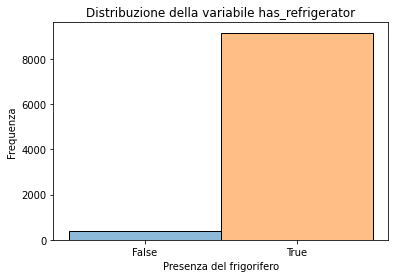

In [ ]:
plot_cat_variable(newcolumn="has_refrigerator", xlabel="Presenza del frigorifero", binary=True)

#### Variabile `v18q` (`has_tablet`)

Questa variabile rappresenta o meno la presenza di almeno un tablet in famiglia.

In [ ]:
cat_variable(mapping = {'v18q': 'has_tablet'}, newcolumn = "has_tablet")

0    7342
1    2215
Name: has_tablet, dtype: int64
Numero di missing values per la variabile has_tablet : 0


Come è possibile notare buona parte degli individui non possiede tablet in famiglia, ma poco più del 20% sì.

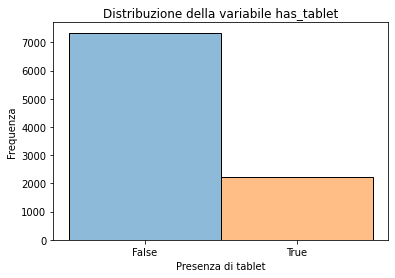

In [ ]:
plot_cat_variable(newcolumn="has_tablet", xlabel="Presenza di tablet", binary=True)

#### Variabile `computer` (`has_computer`)

Questa variabile rappresenta la presenza o meno di almeno un computer in famiglia.

In [ ]:
cat_variable(mapping = {'computer': 'has_computer'}, newcolumn = "has_computer")

0    8581
1     976
Name: has_computer, dtype: int64
Numero di missing values per la variabile has_computer : 0


Anche in questo caso, la stragrande maggioranza non possiede alcun computer in famiglia.

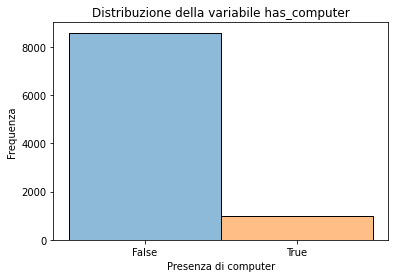

In [ ]:
plot_cat_variable(newcolumn="has_computer", xlabel="Presenza di computer", binary=True)

#### Variabile `television`(`has_television`)

Questa variabile rappresenta la presenza o meno di televisioni in casa dell'individuo considerato.

In [ ]:
cat_variable(mapping = {'television': 'has_television'}, newcolumn = "has_television")

0    6837
1    2720
Name: has_television, dtype: int64
Numero di missing values per la variabile has_television : 0


La maggior parte delle persone non possiedono televisori in casa, solo il 28% lo possiede.

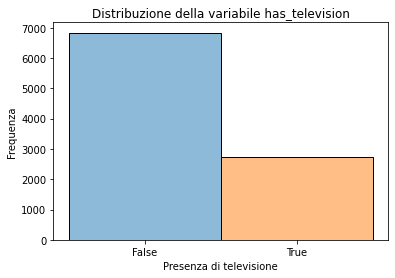

In [ ]:
plot_cat_variable(newcolumn="has_television", xlabel="Presenza di televisione", binary=True)

#### Variabile `mobilephone` (`has_phone`)

Questa variabile rappresenta la presenza o meno di telefoni nella famiglia dell'individuo considerato.

In [ ]:
cat_variable(mapping = {'mobilephone': 'has_phone'}, newcolumn = "has_phone")

1    9321
0     236
Name: has_phone, dtype: int64
Numero di missing values per la variabile has_phone : 0


La maggior parte delle persone appartengono a famiglie che possiedono almeno un telefono.

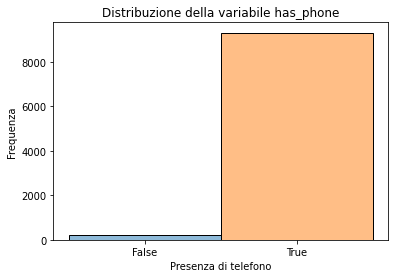

In [ ]:
plot_cat_variable(newcolumn="has_phone", xlabel="Presenza di telefono", binary=True)

#### Variabile `cielorazo` (`has_ceiling`)

Questa variabile rappresenza la presenza di un soffitto in casa.

In [ ]:
cat_variable(mapping = {'cielorazo': 'has_ceiling'}, newcolumn = "has_ceiling")

1    6474
0    3083
Name: has_ceiling, dtype: int64
Numero di missing values per la variabile has_ceiling : 0


Circa i 2/3 delle persone abitano in case con un soffitto.

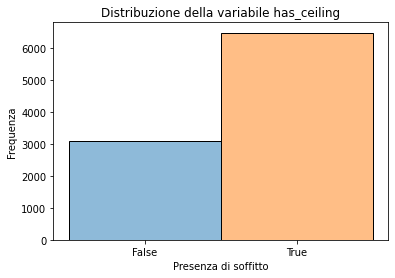

In [ ]:
plot_cat_variable(newcolumn="has_ceiling", xlabel="Presenza di soffitto", binary=True)

#### Variabile `dis` (`is_disabled`)

Questa variabile riporta per ogni persona l'informazione del fatto che sia o meno disabile.

In [ ]:
cat_variable(mapping = {'dis': 'is_disabled'}, newcolumn = "is_disabled")

0    9007
1     550
Name: is_disabled, dtype: int64
Numero di missing values per la variabile is_disabled : 0


La maggior parte delle persone considerate non risulta essere disabile.

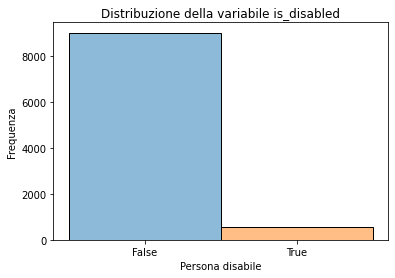

In [ ]:
plot_cat_variable(newcolumn="is_disabled", xlabel="Persona disabile", binary=True)

### Variabili categoriche

Di seguito vengono analizzate le variabili relative alla singola persona.

#### Variabili `female` and `male` (`gender`)
Queste due variabili riportano per ogni individuo l'indicazione del genere. 
Al fine di semplificare la rapresentazione, sono state unite in un'unica variabile `gender`.

In [ ]:
cat_variable(newcolumn="gender", mapping=None, classes = ["female", "male"])

female    4937
male      4620
Name: gender, dtype: int64
Numero di missing values per la variabile gender : 0


La distribuzione di maschi e femmine nel dataset è equilibrata.

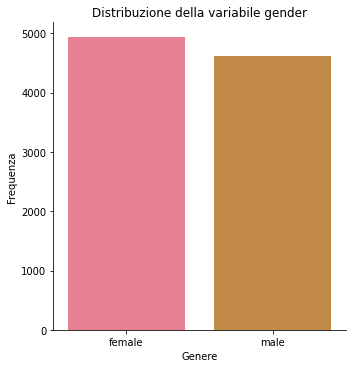

In [ ]:
plot_cat_variable(newcolumn="gender", xlabel="Genere", binary = False)

#### Variabili `estadocivil` (`marital_status`)

La variabile rappresenta lo stato civile degli individui del dataset.

In [ ]:
mapping = {'estadocivil1' : '<10 years old', 'estadocivil2' : 'free/coupled union', 'estadocivil3' : 'married', 'estadocivil4' : 'divorced', 'estadocivil5' : 'separated', 'estadocivil6' : 'widow/er', 'estadocivil7' : 'single'}
classes = ["<10 years old", "free/coupled union", "married", "divorced", "separated", "widow/er", "single"]
cat_variable(newcolumn="marital_status", mapping=mapping, classes=classes)

single                3275
married               2565
<10 years old         1317
free/coupled union    1178
separated              600
widow/er               317
divorced               305
Name: marital_status, dtype: int64
Numero di missing values per la variabile marital_status : 0


La maggior parte delle persone sono single o sposate. 

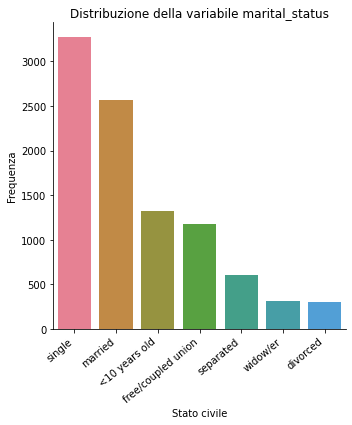

In [ ]:
plot_cat_variable(newcolumn="marital_status", xlabel="Stato civile", binary = False, central = False)

#### Variabili `parentesco` (`relationship`)



Questa variabile rappresenta il grado di parentela che ogni individuo ha con il capofamiglia.

In [ ]:
mapping = {'parentesco1' : 'household head', 'parentesco2' : 'partner', 'parentesco3' : 'child', 'parentesco4' : 'stepchild', 'parentesco5' : 'daughter/son in law', 'parentesco6' : 'grandchild', 'parentesco7' : 'parent', 'parentesco8':'mother/father in law','parentesco9': 'sibling','parentesco10':'sister/brother in law','parentesco11':'relative','parentesco12':'non relative'}
classes = ["household head", "partner", "child", "stepchild", "daughter/son in law", "grandchild", "parent", "mother/father in law","sibling", "sister/brother in law", "relative", "non relative"]
cat_variable(newcolumn="relationship", mapping=mapping, classes=classes)

child                    3649
household head           2973
partner                  1759
grandchild                489
sibling                   127
relative                  121
stepchild                 116
parent                     96
daughter/son in law        91
non relative               83
sister/brother in law      30
mother/father in law       23
Name: relationship, dtype: int64
Numero di missing values per la variabile relationship : 0


Come si può notare, la maggior parte delle persone sono figlie di un capofamiglia. 
Questa categoria è seguita dal numero di capifamiglia e dai partner.

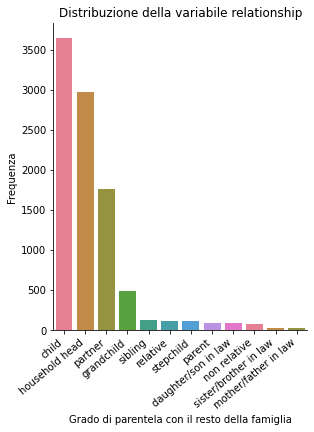

In [ ]:
plot_cat_variable(newcolumn="relationship", xlabel="Grado di parentela con il resto della famiglia", binary = False, central = False)

#### Variabili `instlevel` (`education`) 


Questa variabile rappresenta il tipo di istruzione conseguita da ogni persona.

In [ ]:
df["other"] = 0
df.loc[df[["instlevel1", "instlevel2", "instlevel3", "instlevel4", "instlevel5", "instlevel6", "instlevel7", "instlevel8","instlevel9"]].eq(0).all(1), "other"] = 1

In [ ]:
mapping = {'instlevel1' : 'no educ', 'instlevel2' : 'incompl 1', 'instlevel3' : 'compl 1','instlevel4' : 'incompl acad 2','instlevel5':'compl acad 2','instlevel6':'incompl tech 2','instlevel7':'compl tech 2','instlevel8':'undergrad','instlevel9':'postgrad'}
classes = ["no educ", "incompl 1", "compl 1", "incompl acad 2", "compl acad 2", "incompl tech 2", "compl tech 2", "undergrad","postgrad", "other"]
cat_variable(newcolumn="education", mapping=mapping, classes=classes)

compl 1           1985
incompl acad 2    1772
incompl 1         1630
undergrad         1336
no educ           1287
compl acad 2      1077
incompl tech 2     171
compl tech 2       149
postgrad           147
other                3
Name: education, dtype: int64
Numero di missing values per la variabile education : 0


La distribuzione di questa variabile ha un andamento discendente dai gradi di istruzione più bassi a quelli più alti.

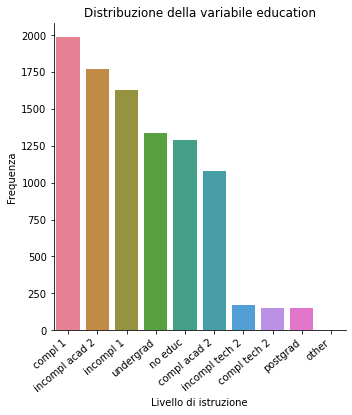

In [ ]:
plot_cat_variable(newcolumn="education", xlabel="Livello di istruzione", binary = False, central = False)

Di seguito vengono analizzate le variabili relative alla casa.

#### Variabili `pared` (`outside_wall`)

Questa variabile rappresenta il materiale di cui sono fatte le pareti della casa in cui vive l'individuo considerato.

In [ ]:
mapping = {'paredblolad': 'block/brick', 'paredzocalo': 'socket', 'paredpreb' : 'cement', 'pareddes' : 'waste material', 'paredmad' : 'wood', 'paredzinc' : 'zink', 'paredfibras' : 'natual fibers', 'paredother' : 'other'}
classes = ["block/brick", "socket", "cement", "waste material", "wood", "zink", "natual fibers", "other"]
cat_variable(newcolumn="outside_wall", mapping=mapping, classes=classes)

block/brick       5677
cement            1797
wood              1105
socket             743
zink               125
waste material      82
natual fibers       14
other               14
Name: outside_wall, dtype: int64
Numero di missing values per la variabile outside_wall : 0


Si può notare come solitamente esse siano fatte di mattoni.

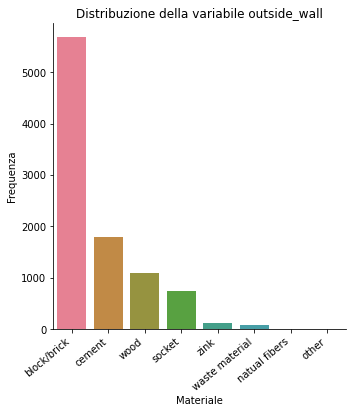

In [ ]:
plot_cat_variable(newcolumn="outside_wall", xlabel="Materiale", binary = False, central = False)

#### Variabili `piso` (`floor`)

Questa variabile rappresenta il materiale di cui è fatto il pavimento della casa in cui vive l'individuo considerato.

In [ ]:
mapping = {'pisomoscer': 'mosaic/ceramic', 'pisocemento': 'cement', 'pisoother' : 'other', 'pisonatur' : 'natural material', 'pisonotiene' : 'no floor', 'pisomadera' : 'wood'}
classes = ["mosaic/ceramic", "cement", "other", "natural material", "no floor", "wood"]
cat_variable(newcolumn="floor", mapping=mapping, classes=classes)

mosaic/ceramic      6621
cement              2130
wood                 630
no floor             157
natural material      10
other                  9
Name: floor, dtype: int64
Numero di missing values per la variabile floor : 0


Principalmente i pavimenti sono composti da mosaici e/o ceramica.

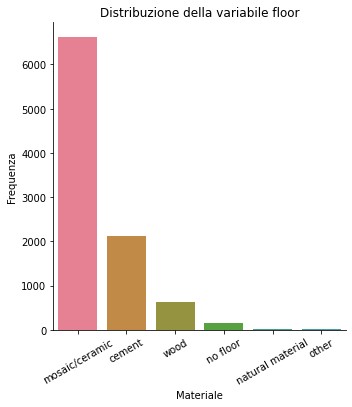

In [ ]:
plot_cat_variable(newcolumn="floor", xlabel="Materiale", binary = False)

#### Variabili `techo` (`roof`)

Questa variabile rappresenta il materiale di cui è fatto il tetto della casa in cui vive l'individuo considerato.

In [ ]:
df.loc[df[["techozinc", "techoentrepiso", "techocane", "techootro"]].eq(0).all(1), "techootro"] = 1

In [ ]:
mapping = {'techozinc': 'metal foil/zink', 'techoentrepiso': 'cement', 'techocane' : 'natural fibers', 'techootro' : 'other'}
classes = ["metal foil/zink", "cement", "natural fibers", "other"]
cat_variable(newcolumn="roof", mapping=mapping, classes=classes)

metal foil/zink    9271
cement              169
other                87
natural fibers       30
Name: roof, dtype: int64
Numero di missing values per la variabile roof : 0


La maggior parte degli indivui abita in case con il tetto di alluminio.

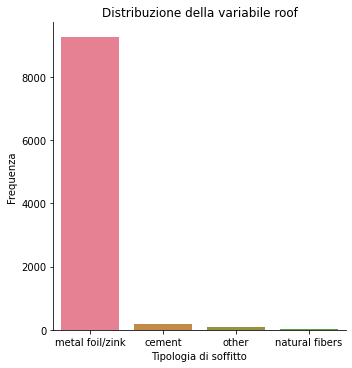

In [ ]:
plot_cat_variable(newcolumn="roof", xlabel="Tipologia di soffitto", binary = False)

#### Variabili `abastagua` (`water_provision`)

Questa variabile rappresenta la tipologia di approvvigionamento dell'acqua.

In [ ]:
mapping = {'abastaguadentro': 'inside', 'abastaguafuera': 'outside', 'abastaguano': 'no water provision'}
classes = ["inside", "outside", "no water provision"]
cat_variable(newcolumn="water_provision", mapping=mapping, classes=classes)

inside                9220
outside                303
no water provision      34
Name: water_provision, dtype: int64
Numero di missing values per la variabile water_provision : 0


La maggioranza delle persone ha l'acqua in casa.

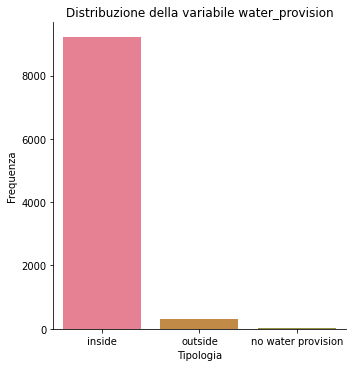

In [ ]:
plot_cat_variable(newcolumn="water_provision", xlabel="Tipologia", binary = False)

#### Variabili `public`, `planpri`, `noelec`, `coopele` (`electricity_source`)
Questa variabile rappresenta la tipologia di impianto elettrico presente all'interno dell'abitazione.

In [ ]:
df["other"] = 0
df.loc[df[["public", "planpri", "noelec", "coopele"]].eq(0).all(1), "other"] = 1

In [ ]:
mapping = {'planpri': 'private plant', 'noelec': 'no electricity', 'coopele': 'cooperative'}
classes = ["public", "private plant", "no electricity", "cooperative", "other"]
cat_variable(newcolumn="electricity_source", mapping=mapping, classes=classes)

public            8459
cooperative       1059
no electricity      21
other               15
private plant        3
Name: electricity_source, dtype: int64
Numero di missing values per la variabile electricity_source : 0


La maggior parte delle persone ha un impianto elettrico pubblico.

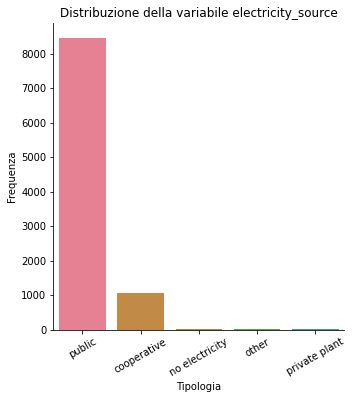

In [ ]:
plot_cat_variable(newcolumn="electricity_source", xlabel="Tipologia", binary = False)

#### Variabili `sanitario` (`toilet_system`)
Questa variabile rappresenta la tipologia di sistema di servizi igienici presente all'interno dell'abitazione.

In [ ]:
mapping = {'sanitario1': 'dwelling', 'sanitario2': 'sewer/cesspool', 'sanitario3': 'septic cell', 'sanitario5': 'black hole/letrine', 'sanitario6': 'other'}
classes = ["dwelling", "sewer/cesspool", "septic cell", "black hole/letrine", "other"]
cat_variable(newcolumn="toilet_system", mapping=mapping, classes=classes)

septic cell           7304
sewer/cesspool        2045
black hole/letrine     147
dwelling                37
other                   24
Name: toilet_system, dtype: int64
Numero di missing values per la variabile toilet_system : 0


La tipologia più diffusa è `septic cell`.

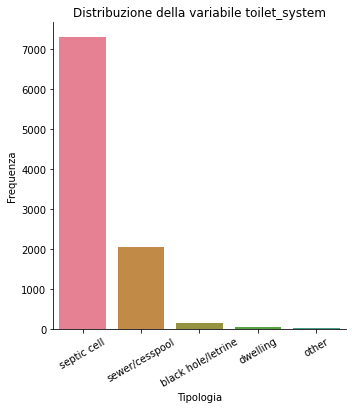

In [ ]:
plot_cat_variable(newcolumn="toilet_system", xlabel="Tipologia", binary = False)

#### Variabili `energcocinar` (`energy`)
Questa variabile rappresenta la tipologia di cucina presente all'interno dell'abitazione.

In [ ]:
mapping = {'energcocinar1': 'no kitchen', 'energcocinar2': 'electricity', 'energcocinar3': 'gas', 'energcocinar4': 'wood charcoal'}
classes = ["no kitchen", "electricity", "gas", "wood charcoal"]
cat_variable(newcolumn="energy", mapping=mapping, classes=classes)

electricity      4679
gas              4381
wood charcoal     479
no kitchen         18
Name: energy, dtype: int64
Numero di missing values per la variabile energy : 0


Le due tipologie più diffuse sono le cucine elettriche e quelle a gas.

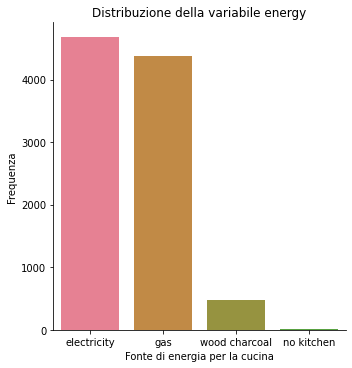

In [ ]:
plot_cat_variable(newcolumn="energy", xlabel="Fonte di energia per la cucina", binary = False)

#### Variabili `elimbasu` (`rubbish_disposal`)

Questa variabile rappresenta il sistema di smaltimento dei rifiuti.

In [ ]:
mapping = {'elimbasu1' : 'tanker truck', 'elimbasu2' : 'botan hollow/buried', 'elimbasu3' : 'burning', 'elimbasu4' : 'unoccupied space', 'elimbasu5' : 'river/creek/sea', 'elimbasu6' : 'other'}
classes = ["tanker truck", "botan hollow/buried", "burning", "unoccupied space", "river/creek/sea", "other"]
cat_variable(newcolumn="rubbish_disposal", mapping=mapping, classes=classes)

tanker truck           8436
burning                 808
botan hollow/buried     287
unoccupied space         14
other                    12
Name: rubbish_disposal, dtype: int64
Numero di missing values per la variabile rubbish_disposal : 0


Il sistema più diffuso è è quello di portar via i rifiuti per mezzo di camion della spazzatura.

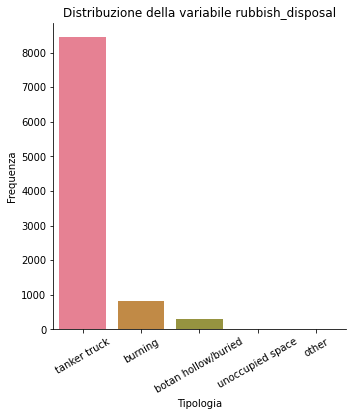

In [ ]:
plot_cat_variable(newcolumn="rubbish_disposal", xlabel="Tipologia", binary = False)

#### Variabili `etecho` (`roof_status`)

Questa variabile indica lo stato del tetto della casa dell'individuo considerato.

In [ ]:
mapping = {'etecho1' : 'bad', 'etecho2' : 'regular', 'etecho3' : 'good'}
classes = ["bad", "regular", "good"]
cat_variable(newcolumn="roof_status", mapping=mapping, classes=classes)

good       5577
regular    2753
bad        1227
Name: roof_status, dtype: int64
Numero di missing values per la variabile roof_status : 0


La maggior parte dei tetti sono in buono stato.

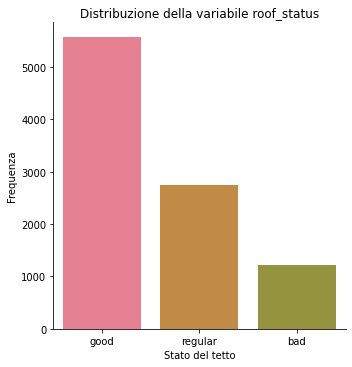

In [ ]:
plot_cat_variable(newcolumn="roof_status", xlabel="Stato del tetto", binary = False)

#### Variabili `eviv` (`floor_status`)


Questa variabile indica lo stato del pavimento della casa dell'individuo considerato.

In [ ]:
mapping = {'eviv1' : 'bad', 'eviv2' : 'regular', 'eviv3' : 'good'}
classes = ["bad", "regular", "good"]
cat_variable(newcolumn="floor_status", mapping=mapping, classes=classes)

good       6175
regular    2416
bad         966
Name: floor_status, dtype: int64
Numero di missing values per la variabile floor_status : 0


La maggior parte dei pavimenti sono in buono stato.

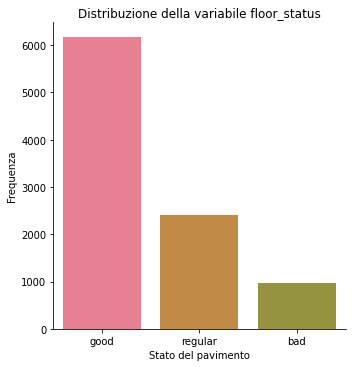

In [ ]:
plot_cat_variable(newcolumn="floor_status", xlabel="Stato del pavimento", binary = False)

#### Varibili `epared` (`walls_status`)

Questa variabile indica lo stato dei muri della casa dell'individuo considerato.

In [ ]:
mapping = {'epared1' : 'bad', 'epared2' : 'regular', 'epared3' : 'good'}
classes = ["bad", "regular", "good"]
cat_variable(newcolumn="walls_status", mapping=mapping, classes=classes)

good       5449
regular    3129
bad         979
Name: walls_status, dtype: int64
Numero di missing values per la variabile walls_status : 0


La maggior parte dei muri delle case sono in buono stato.

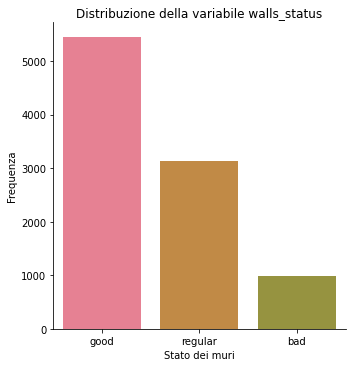

In [ ]:
plot_cat_variable(newcolumn="walls_status", xlabel="Stato dei muri", binary = False)

#### Variabili `tipoviv` (`type_of_contract`)


Questa variabile indica il tipo di contratto che la famiglia ha stipulato per la casa.

In [ ]:
mapping = {'tipovivi1' : 'own and fully paid house', 'tipovivi2' : 'own, paying in installments', 'tipovivi3' : 'rented', 'tipovivi4':'precarious','tipovivi5':'other assigned/borrowed'}
classes = ["own and fully paid house", "own, paying in installments", "rented", "precarious", "other assigned/borrowed"]
cat_variable(newcolumn="type_of_contract", mapping=mapping, classes=classes)

own and fully paid house       5911
rented                         1736
own, paying in installments     961
other assigned/borrowed         786
precarious                      163
Name: type_of_contract, dtype: int64
Numero di missing values per la variabile type_of_contract : 0


La maggior parte sono case di proprietà, seguite in numero da abitazioni affittate.

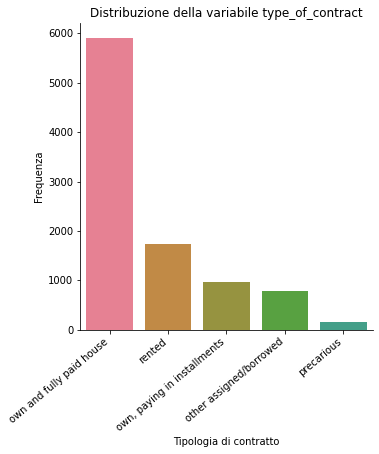

In [ ]:
plot_cat_variable(newcolumn="type_of_contract", xlabel="Tipologia di contratto", binary = False, central = False)

Questa variabile viene usata per cercare di capire meglio a cosa corrispondono i missing values presenti in `monthly_rent_payment`.

In [ ]:
print("Ad ogni \"own and paid house\" corrisponde un missing value nella colonna \"monthly_rent_payment\"?")
print(df.loc[df["type_of_contract"] == "own and fully paid house", "monthly_rent_payment"].isnull().all())

Ad ogni "own and paid house" corrisponde un missing value nella colonna "monthly_rent_payment"?
True


A tutti gli individui che vivono in una casa di proprietà viene quindi assegnato un affitto mensile pari a 0.

In [ ]:
df.loc[df["type_of_contract"] == "own and fully paid house", "monthly_rent_payment"] = df.loc[df["type_of_contract"] == "own and fully paid house", "monthly_rent_payment"].fillna(0)

In [ ]:
df.loc[df["monthly_rent_payment"].isnull(), "type_of_contract"].value_counts()

other assigned/borrowed    786
precarious                 163
Name: type_of_contract, dtype: int64

Le altre persone per cui l'affitto è sconosciuto sono persone a cui la casa è stata prestata o la cui permanenza nell'abitazione è temporanea.

Si è deciso pertanto di porre l'affitto a 0 per le persone a cui la casa è stata prestata, mentre di lasciare i missing values per gli altri.

In [ ]:
df.loc[df["type_of_contract"] == "other assigned/borrowed", "monthly_rent_payment"] = df.loc[df["type_of_contract"] == "other assigned/borrowed", "monthly_rent_payment"].fillna(0)

La variabile `monthly_rent_payment` risulta ora avere una distribuzione molto diversa.

In [ ]:
df["monthly_rent_payment"].value_counts()

0.0         6726
150000.0     233
100000.0     181
200000.0     159
120000.0     149
            ... 
253000.0       1
118097.0       1
108000.0       1
542013.0       1
119813.0       1
Name: monthly_rent_payment, Length: 157, dtype: int64

Solo poche persone infatti ora devono pagare un'affitto mensile.

Vengono quindi visualizzati due grafici, uno che riporti tutti i valori dell'affitto mensile e uno solo per gli affitti maggiori di 0.

Text(0, 0.5, 'Frequenza')

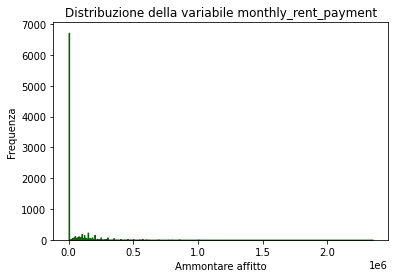

In [ ]:
sns.histplot(df["monthly_rent_payment"], element="step", color="darkgreen")
plt.title('Distribuzione della variabile monthly_rent_payment')
plt.xlabel('Ammontare affitto')
plt.ylabel('Frequenza')

Text(0, 0.5, 'Frequenza')

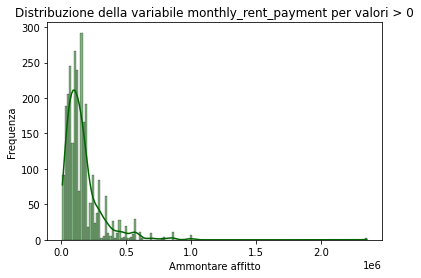

In [ ]:
sns.histplot(df.loc[df["monthly_rent_payment"]>0, "monthly_rent_payment"], element="bars", kde=True, color="darkgreen")
plt.title('Distribuzione della variabile monthly_rent_payment per valori > 0')
plt.xlabel('Ammontare affitto')
plt.ylabel('Frequenza')

Data però l'impossibilità di accertare il valore di `monthly_rent_payment` per gli ultimi missing values rimasti, si è decido di rimuovere la variabile.

In [ ]:
df = df.drop('monthly_rent_payment', axis = 1)

#### Variabili `lugar` (`region`) 


Questa variabile rappresenta la regione in cui l'individuo vive.

In [ ]:
mapping = {'lugar1' : 'Central', 'lugar2' : 'Chorotega', 'lugar3' : 'Pacafafico Central', 'lugar4':'Brunca','lugar5':'Huetar Atlantica', 'lugar6':'Huetar Norte'}
classes = ["Central", "Chorotega", "Pacafafico Central","Brunca", "Huetar Atlantica", "Huetar Norte"]
cat_variable(newcolumn="region", mapping=mapping, classes=classes)

Central               5616
Huetar Atlantica       897
Chorotega              886
Brunca                 791
Huetar Norte           771
Pacafafico Central     596
Name: region, dtype: int64
Numero di missing values per la variabile region : 0


La maggior parte delle persone vive nella regione centrale.

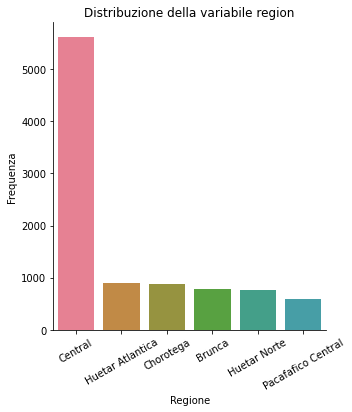

In [ ]:
plot_cat_variable(newcolumn="region", xlabel="Regione", binary = False)

#### Variabili `area` (`area`) 

Questa variabile rappresenta la tipologia di area (se urbana o rurale) in cui vive ogni persona.

In [ ]:
mapping = {'area1' : 'urban', 'area2' : 'rural'}
classes = ["urban", "rural"]
cat_variable(newcolumn="area", mapping=mapping, classes=classes)

urban    6829
rural    2728
Name: area, dtype: int64
Numero di missing values per la variabile area : 0


La maggior parte delle persone vive nell'area urbana.

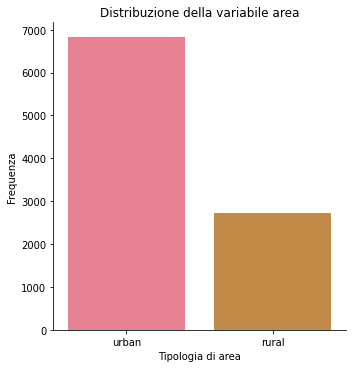

In [ ]:
plot_cat_variable(newcolumn="area", xlabel="Tipologia di area", binary = False)

Da ultimo, vengono rimosse le variabili che riportano semplicemente il valore al quadrato di altre variabili, in quanto non utili per l'analisi.

In [ ]:
df.drop(["SQBescolari", "SQBage", "SQBhogar_total", "SQBedjefe", "SQBhogar_nin", "SQBovercrowding", "SQBdependency", "SQBmeaned", "agesq"], inplace=True, axis=1)

### Variabile `target`

La variabile target riporta il grado di povertà/richezza e quindi di vulnerabilità di ogni famiglia. 

Nello specifico esso può essere: 

- 1 = extreme poverty 
- 2 = moderate poverty 
- 3 = vulnerable households 
- 4 = non vulnerable households

In [ ]:
num_variable(column="target", mapping={'Target': 'target'}, ordinal=True)

Categoria  Frequenza
4    5996
2    1597
3    1209
1     755
Name: target, dtype: int64
Numero di missing values per la variabile target : 0


La variabile target risulta essere sbilanciata in particolare per quanto riguarda la classe 4, quella delle famiglie non vulnerabili, che sono nettamente in maggioranza. 



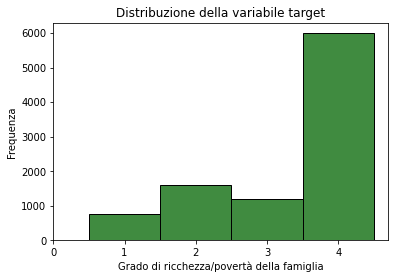

In [ ]:
plot_num_variable(column="target", xlabel="Grado di ricchezza/povertà della famiglia", many_values=False, nonzero=True) 

Bisogna però considerare che il dataset riporta i dati per persona e non per famiglia, quindi questo potrebbe essere uno dei motivi che incide sullo sbilanciamento. 

# Preprocessing

In questa fase di preparazione alla creazione della rete neurale, mostriamo la dimensione attuale del dataset dopo aver svolto tutta l'analisi delle variabili e aver eliminato quelle ritenute non utili. 

All'elenco di variabili rimosse vengono aggiunte  `Id`, identificativo delle singole persone, e `id_family`, identificativo delle famiglie. 
Quest'ultima viene eliminata in quanto non è possibile mantenere la sua informazione né tramite one hot encode (determinerebbe la creazione di poco meno di 3000 colonne), né trasformandola semplicemente in una variabile numerica (assumerebbe erroneamente le caratteristiche di una variabile ordinale).

In [ ]:
df = df.drop(['Id', 'id_family'], axis = 1)

In [ ]:
print("Nuova dimensione del dataset:", df.shape)
print("Colonne rimanenti nel dataset:", df.columns)

Nuova dimensione del dataset: (9557, 39)
Colonne rimanenti nel dataset: Index(['rooms', 'has_bathroom', 'has_refrigerator', 'has_tablet',
       'num_tablets', 'tot_males', 'tot_females', 'education_years',
       'has_ceiling', 'is_disabled', 'num_children', 'num_adults',
       'num_elderly', 'bedrooms', 'has_computer', 'has_television',
       'has_phone', 'num_phones', 'age', 'target', 'household_head_education',
       'gender', 'marital_status', 'relationship', 'education', 'outside_wall',
       'floor', 'roof', 'water_provision', 'electricity_source',
       'toilet_system', 'energy', 'rubbish_disposal', 'roof_status',
       'floor_status', 'walls_status', 'type_of_contract', 'region', 'area'],
      dtype='object')


Si è quindi passati da una dataset di 143 features a uno di 39.

Per il preprocessing vengono tentate due strade: una utilizzando Factor Analysis of Mixed Data (FAMD), tecnica adatta per dataset con variabili numeriche e categoriche, e una utilizzado One Hot Encode per le variabili categoriche.

## Factor Analysis of Mixed Data (FAMD) 

Si tratta di un principal component method dedicato all'analisi di dataset contenenti variabili sia qualitative che quantitative. Permette quindi di analizzare la similarità tra gli individui prendendo in considerazione variabili di diverso tipo.

In [ ]:
famd = prince.FAMD(
     n_components=df.shape[1]-1,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42)

Il dataset (ad eccezione della variabil target) viene trasformato utilizzando `famd.fit_transform()` della libreria `prince`.

In [ ]:
X_famd = famd.fit_transform(df.loc[:, df.columns!="target"])

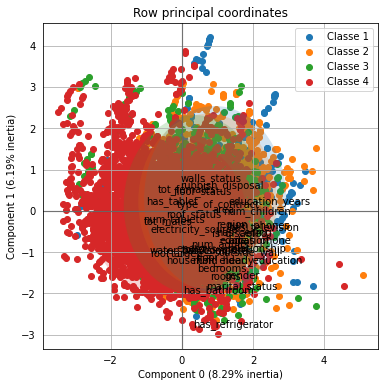

In [ ]:
ax = famd.plot_row_coordinates(
    X=df,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    labels=df.columns,
    color_labels=['Classe {}'.format(t) for t in df["target"]],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True)

In [ ]:
X_famd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,0.797005,-1.669537,-0.941314,0.093877,-0.198921,0.871343,-0.081044,-0.673289,-0.326305,0.252287,-0.898582,-0.159423,0.152752,0.194103,-0.632498,-0.171604,0.079111,-0.133256,0.620385,-0.374777,-0.015546,-0.465318,-0.048271,0.149172,0.096014,-0.470777,0.490349,0.070462,-0.997067,0.309823,0.117718,-0.951219,-0.096909,-0.825197,0.309897,0.083939,0.344319,0.800917
1,0.031448,-1.981164,-0.717655,0.831808,0.095501,-0.443339,-0.610550,0.069195,-0.196622,1.063563,-1.192951,-0.298353,0.065278,0.288406,-0.898860,-0.412858,0.555553,-0.401186,0.687500,0.005739,0.374122,0.328843,-0.286310,0.767901,0.548699,-0.343402,-0.580673,-0.082342,0.115260,-0.254155,-0.175533,0.084724,-0.087405,-0.197150,0.527803,0.188398,0.438566,0.108410
2,0.321086,-2.801502,1.499289,-0.280157,2.049573,-0.162106,-0.193538,1.400995,0.134554,-0.152174,-1.292408,1.023666,-0.052953,0.532258,0.758478,0.975799,-1.165255,-0.415010,0.068745,0.266125,-0.762788,0.083772,-0.301259,0.367990,0.203423,-0.062713,0.305306,-0.029269,0.176334,-0.376458,-0.281818,-0.576179,0.483901,0.411369,0.283460,0.117905,-0.454342,-0.095889
3,-1.008993,0.176624,-1.179704,0.194460,0.219886,0.019395,0.179254,-0.003763,-0.139250,0.053367,-0.675285,0.303178,0.294978,-0.273559,-0.544929,0.472195,0.213844,-0.171134,0.228536,-0.049058,-0.167172,0.220007,0.060765,-0.266996,0.077273,0.055204,-0.003490,-0.159894,-0.330288,0.043577,-0.064402,0.087634,0.121819,-0.063120,0.069016,-0.168536,-0.210489,0.015838
4,-1.098358,-0.261883,-0.929083,0.362934,0.025881,0.074616,-0.296252,-0.018391,0.865037,-0.128404,-0.429591,-0.138136,0.092869,0.001401,-0.316610,0.272935,0.413930,-0.197096,-0.092150,0.247576,-0.491451,0.092986,0.383661,-0.131824,0.100076,-0.533969,0.445483,-0.028269,-0.143424,-0.291145,-0.083708,0.108270,0.409866,0.283112,0.495637,0.213721,-0.367267,0.080349


## One Hot Encoder

One Hot Encode applicato alle variabili categoriche rappresenta la seconda alternativa. Questo permette di passare da colonne contenenti stringhe a colonne binarie. 

Vengono quindi selezionate le colonne categoriche da convertire (`cat_features`).

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
cat_features = ['gender','marital_status','relationship','education','outside_wall','floor','roof','water_provision','electricity_source',
                'toilet_system','energy','rubbish_disposal','roof_status','floor_status','walls_status','type_of_contract','region','area']

Le colonne convertite vengono salvate in `enc_df`. 

In [ ]:
#encoder per tutte le features categoriche
enc_df = pd.DataFrame(enc.fit_transform(df[cat_features]).toarray())

`enc_df` viene quindi poi aggiunto al dataset originario `df`, da cui vengono rimosse le vecchie variabili categoriche. 
Infine, le variabili vengono portate a int.

In [ ]:
df = df.join(enc_df)
df = df.drop(cat_features, axis=1)
df_final = df.astype(int)

In [ ]:
print("Nuova dimensione del dataset:", df_final.shape)
print("Colonne del dataset:", df_final.columns)

Nuova dimensione del dataset: (9557, 114)
Colonne del dataset: Index([           'rooms',     'has_bathroom', 'has_refrigerator',
             'has_tablet',      'num_tablets',        'tot_males',
            'tot_females',  'education_years',      'has_ceiling',
            'is_disabled',
       ...
                       83,                 84,                 85,
                       86,                 87,                 88,
                       89,                 90,                 91,
                       92],
      dtype='object', length=114)


Il dataset con One Hot Encode risulta quindi formato da 114 features.

# Train, Test e Validation Split

Per entrambe le modalità di preprocessing, vengono effettuate le divisioni in train, test e validation set.

## Train, test e validation per FAMD dataset

Viene effettuata una prima divisione in train e test (80-20) per il dataset ottenuto con FAMD.

In [ ]:
X_train_famd, X_test_famd, y_train_famd, y_test_famd = train_test_split(X_famd, df["target"], test_size=0.2, random_state=42, shuffle=True)

Dopodichè, le label di entrambi training e test set vengono portate da valore numerico a one hot encode. Inoltre, le classi vengono scalate per comodità al range 0-3. 
- classe 4 -> 3
- classe 3 -> 2
- classe 2 -> 1
- classe 1 -> 0

In [ ]:
y_train_famd = keras.utils.to_categorical(y_train_famd-1)
y_test_famd = keras.utils.to_categorical(y_test_famd-1)

In [ ]:
print("Dimensione del training set:", X_train_famd.shape, y_train_famd.shape)
print("Dimensione del test set:", X_test_famd.shape, y_test_famd.shape)

Dimensione del training set: (7645, 38) (7645, 4)
Dimensione del test set: (1912, 38) (1912, 4)


Infine, viene effettuate la divisione del training set in train e validation set (80-20).

In [ ]:
X_train_famd, X_val_famd, y_train_famd, y_val_famd = train_test_split(X_train_famd, y_train_famd, random_state=42, shuffle=True, train_size=0.8)
print("Dimensione del training set:", X_train_famd.shape, y_train_famd.shape)
print("Dimensione del validation set:", X_val_famd.shape, y_val_famd.shape)

Dimensione del training set: (6116, 38) (6116, 4)
Dimensione del validation set: (1529, 38) (1529, 4)


## Train, test e validation per OHE dataset

Viene effettuata una prima divisione in train e test (80-20) per il dataset ottenuto con OHE.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_final.loc[:, df_final.columns!="target"], 
    (df_final["target"]), 
    test_size=0.2, random_state=42, shuffle=True)

Viene utilizzato `StandardScaler()` per scalare i dati di train e test e renderli comparabili fra loro.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

Dopodichè, le label di entrambi training e test set vengono portate da valore numerico a one hot encode. Inoltre, le classi vengono scalate per comodità al range 0-3. 
- classe 4 -> 3
- classe 3 -> 2
- classe 2 -> 1
- classe 1 -> 0

In [ ]:
y_train = keras.utils.to_categorical(y_train-1)
y_test = keras.utils.to_categorical(y_test-1)

In [ ]:
print("Dimensione del training set:", X_train.shape, y_train.shape)
print("Dimensione del test set:", X_test.shape, y_test.shape)

Dimensione del training set: (7645, 113) (7645, 4)
Dimensione del test set: (1912, 113) (1912, 4)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, shuffle=True, train_size=0.8)
print("Dimensione del training set:", X_train.shape, y_train.shape)
print("Dimensione del validation set:", X_val.shape, y_val.shape)

Dimensione del training set: (6116, 113) (6116, 4)
Dimensione del validation set: (1529, 113) (1529, 4)


# Reti neurali senza regolarizzazione

Vengono quindi istanziate alcune variabili, in seguito utilizzate per creare le reti neurali.

In [ ]:
num_classes = len(df_final['target'].unique()) #numero di classi
num_epochs = 300
activation = "relu"
dim_famd = X_train_famd.shape[1] #numero di feature nel dataset FAMD
dim = X_train.shape[1] #numero di feature nel dataset OHE
initializer = tf.keras.initializers.GlorotUniform(seed=1234)

###Rete FAMD

Il metodo `NeuralNetwork_famd()` definisce e crea la rete neurale per il dataset FAMD. 

Si tratta di una rete composta da 4 layer con un numero di neuroni decrescente (64, 32, 16, 4), adatto a un numero di feature (38) non molto alto.

Dal momento che l'obiettivo è eseguire una classificazione su 4 classi è stata scelta come funzione di attivazione dell'ultimo layer `softmax` e come loss `categorical_crossentropy` (scelte più adatte per il tipo di task). 

L'optimizer `adam` è stato scelto in quanto meglio performante di altri ottimizzatori provati. 

Viene tenuta traccia della metrica `accuracy` per valutare le prestazioni del modello.

In [ ]:
def NeuralNetwork_famd(act, n_inputs, n_outputs): 

  model = Sequential()
  model.add(Dense(64, activation = act, input_shape=n_inputs, kernel_initializer=initializer))
  model.add(Dense(32, activation = act, kernel_initializer=initializer))
  model.add(Dense(16, activation = act, kernel_initializer=initializer))
  model.add(Dense(n_outputs, activation = "softmax", kernel_initializer=initializer))
  
  model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]) 

  return model

Viene creata la rete per il dataset FAMD, tramite `NeuralNetwork_famd()`.

In [ ]:
model_famd = NeuralNetwork_famd(act = activation, 
                          n_inputs=(dim_famd,), 
                          n_outputs = num_classes)

La rete risulta essere come precedentemente descritta. 
È inoltre possibile notare la scarsa quantità di parametri necessari.

In [ ]:
model_famd.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2496      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 5,172
Trainable params: 5,172
Non-trainable params: 0
_________________________________________________________________


La rete viene infine addestrata per 300 epoche, al fine di capirne meglio l'andamento su un numero di iterazioni sufficientemnte lungo, e un `batch_size` di 128, compromesso tra le dimensioni 64 e 256, in quanto nessuna della tre portava a risultati notevolmente migliori.

In [ ]:
history_famd = model_famd.fit(X_train_famd, y_train_famd, batch_size = 128,
                    epochs = num_epochs, verbose = 1,
                    validation_data = (X_val_famd, y_val_famd))

K.clear_session()

Epoch 1/300
48/48 [==============================] - 1s 7ms/step - loss: 1.1693 - accuracy: 0.5551 - val_loss: 1.0140 - val_accuracy: 0.6194
Epoch 2/300
48/48 [==============================] - 0s 3ms/step - loss: 0.9266 - accuracy: 0.6372 - val_loss: 0.9154 - val_accuracy: 0.6351
Epoch 3/300
48/48 [==============================] - 0s 2ms/step - loss: 0.8663 - accuracy: 0.6583 - val_loss: 0.8896 - val_accuracy: 0.6527
Epoch 4/300
48/48 [==============================] - 0s 3ms/step - loss: 0.8409 - accuracy: 0.6740 - val_loss: 0.8779 - val_accuracy: 0.6573
Epoch 5/300
48/48 [==============================] - 0s 2ms/step - loss: 0.8225 - accuracy: 0.6833 - val_loss: 0.8670 - val_accuracy: 0.6612
Epoch 6/300
48/48 [==============================] - 0s 3ms/step - loss: 0.8067 - accuracy: 0.6887 - val_loss: 0.8589 - val_accuracy: 0.6645
Epoch 7/300
48/48 [==============================] - 0s 3ms/step - loss: 0.7927 - accuracy: 0.6920 - val_loss: 0.8519 - val_accuracy: 0.6625
Epoch 8/300
4

Risultati ottenuti alla 300esima epoca:

Set        | Loss  | Accuracy 
-----------|-------|----------
Train      |0.006  |0.999 
Validation |2.594  |0.749 

Sia per la loss che per l'accuracy otteniamo risultati peggiori sul validation set, denotando overfitting. 
In particolare, la loss sul validation set risulta essere in generale molto alta arrivando a 2.6.

Il metodo `plot_history()` consente di visualizzare le history di loss e accuracy per training e validation set nel corso delle epoche, per mezzo di due grafici.

In [ ]:
x_plot = list(range(1,num_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

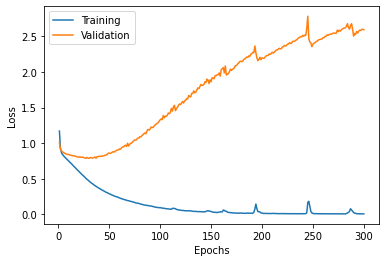

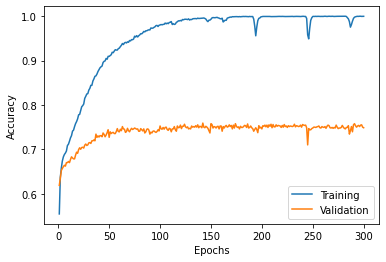

In [ ]:
plot_history(history_famd)

Come possiamo notare, i grafici visualizzano meglio i problemi precedentemente riscontrati. 
Al di là di un forte overfitting, la loss del validation set cresce durante il corso delle epoche invece che diminuire.
Il modello in generale non generalizza bene. 

### Rete OHE

Il metodo `NeuralNetwork` definisce e crea la rete neurale per il dataset OHE. In seguito, verrà fatto riferimento a questa rete come "rete base".

Si tratta di una rete composta da 5 layer con un numero di neuroni decrescente (128, 64, 32, 16, 4), adatto a un numero di feature (113) decisamente più alto di prima.
È stato effettuato anche un tentativo aggiungendo all'inzio un layer da 256, ma ha portato a risultati uguali se non peggiori ed è pertanto stato rimosso.

Dal momento che l'obiettivo è eseguire una classificazione su 4 classi è stata scelta come funzione di attivazione dell'ultimo layer `softmax` e come loss `categorical_crossentropy` (scelte più adatte per il tipo di task). 

L'optimizer `adam` è stato scelto in quanto meglio performante di altri ottimizzatori provati. L'ottimizzatore in questione ha riportato risultati migliori con l'utilizzo del learning rate di default piuttosto che con qualche sua modifica.

Viene tenuta traccia della metrica `accuracy` per valutare le prestazioni del modello.

In [ ]:
def NeuralNetwork(act, n_inputs, n_outputs): 
  model = Sequential()
  model.add(Dense(128, activation= act, input_shape=n_inputs, kernel_initializer=initializer))
  model.add(Dense(64, activation = act, kernel_initializer=initializer))
  model.add(Dense(32, activation = act, kernel_initializer=initializer))
  model.add(Dense(16, activation = act, kernel_initializer=initializer))
  model.add(Dense(n_outputs, activation = "softmax", kernel_initializer=initializer))
  model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]) 
  return model

Viene creata la rete per il dataset OHE, tramite `NeuralNetwork()`.

In [ ]:
model_OHE = NeuralNetwork(act = activation, n_inputs=(dim,), n_outputs = num_classes)

La rete risulta essere come precedentemente descritta. 
È inoltre possibile notare la decisamente maggior quantità di parametri necessari rispetto a FAMD.

In [ ]:
model_OHE.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14592     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 25,524
Trainable params: 25,524
Non-trainable params: 0
_________________________________________________________________


La rete viene infine addestrata per 300 epoche, al fine di capirne meglio l'andamento su un numero di iterazioni sufficientemnte lungo, e un `batch_size` di 128, compromesso tra le dimensioni 64 e 256, in quanto nessuna della tre portava a risultati notevolmente migliori.

In [ ]:
history_OHE = model_OHE.fit(X_train, y_train, batch_size = 128, 
                    epochs = num_epochs, verbose = 1,
                    validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
48/48 [==============================] - 1s 6ms/step - loss: 1.0552 - accuracy: 0.5999 - val_loss: 0.9170 - val_accuracy: 0.6449
Epoch 2/300
48/48 [==============================] - 0s 4ms/step - loss: 0.8566 - accuracy: 0.6674 - val_loss: 0.8682 - val_accuracy: 0.6566
Epoch 3/300
48/48 [==============================] - 0s 3ms/step - loss: 0.7866 - accuracy: 0.6918 - val_loss: 0.8468 - val_accuracy: 0.6684
Epoch 4/300
48/48 [==============================] - 0s 3ms/step - loss: 0.7286 - accuracy: 0.7212 - val_loss: 0.8195 - val_accuracy: 0.6821
Epoch 5/300
48/48 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.7541 - val_loss: 0.8060 - val_accuracy: 0.6985
Epoch 6/300
48/48 [==============================] - 0s 3ms/step - loss: 0.6011 - accuracy: 0.7760 - val_loss: 0.7860 - val_accuracy: 0.7083
Epoch 7/300
48/48 [==============================] - 0s 3ms/step - loss: 0.5360 - accuracy: 0.8049 - val_loss: 0.7696 - val_accuracy: 0.7116
Epoch 8/300
4

Risultati ottenuti alla 300esima epoca: 

Set        | Loss      | Accuracy 
-----------|-----------|----------
Train      |0.002      |0.999  
Validation |1.839      |0.822

Notiamo subito che rispetto a FAMD i risultati sono migliori. 
L'accuracy sul validation set è molto buona (0.82), la loss continua a non essere bassissima.
Ci troviamo anche qui in un caso di overfitting, in quanto invece i risultati sul training set sono ottimali.

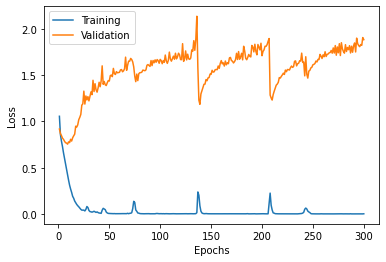

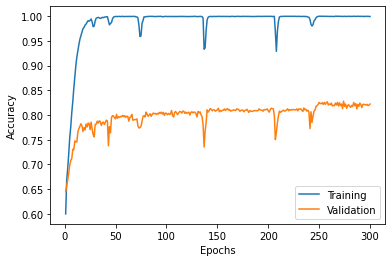

In [ ]:
plot_history(history_OHE)

Gli andamenti di loss e accuracy sono oscillanti, ma la tendenza per l'accuracy della validation è quella di crescere mentre per la loss risulta più difficile capirne la tendenza che sembra però in leggera crescita. 
Anche in questo caso i risultati ottenuti non sono particolarmente buoni, soprattutto per quanto riguarda la loss.

# Rete neurale con regolarizzazione

Per cercare di contrastare il fenomeno di overfitting sono quindi state provate varie tecniche di regolarizzazione, nello specifico: Dropout, L1, L2 e Early Stopping.

Da questo momento in poi verrà considerato solo il dataset OHE, per ridurre la portata degli esperimenti e in quanto dopo questa prima analisi sembra essere quello che consente di avere risultati migliori. Alla prima rete ottenuta con il dataset OHE si farà spesso riferimento come "rete base".

###Dropout

La prima tecnica considerata è il Dropout, metodo di regolarizzazione che permette durante la fase di training di considerare (in alcuni layer) solo una porzione randomica dei neuroni (e delle connessioni).

Il metodo `NeuralNetworkDropout()` permette di definire la stessa rete neurale base aggiungendo però dei layer di Dropout dopo il secondo, il terzo e il quarto layer.
Risulta infatti importante non rimuovere neuroni dal primo e dall'ultimo layer per non rimuovere parte dell'input e dell'output.
Nella lista `v` sono presenti le percentuali di neuroni da rimuovere in ogni layer.

In [ ]:
def NeuralNetworkDropout(act, n_inputs, n_outputs, v): 

  model = Sequential()
  model.add(Dense(128, activation= act, input_shape=n_inputs, kernel_initializer=initializer))
  model.add(Dense(64, activation = act, kernel_initializer=initializer))
  model.add(Dropout(v[0]))
  model.add(Dense(32, activation = act, kernel_initializer=initializer))
  model.add(Dropout(v[1]))
  model.add(Dense(16, activation = act, kernel_initializer=initializer))
  model.add(Dropout(v[2]))
  model.add(Dense(n_outputs, activation = "softmax", kernel_initializer=initializer))

  model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]) 
  return model

Viene quindi creata una rete con layer Dropout in cui: 
- al secondo layer vengono rimossi il 30% dei neuroni.
- al terzo layer, il 20% dei neuroni.
- al quarto layer, il 10% dei neuroni.

Le percentuali sono state scelte in seguito a diverse prove e tentativi. In generale la scelta è stata dettata dal non voler rimuovere porzioni troppo grandi di neuroni.

In [ ]:
model_dropout = NeuralNetworkDropout(act = activation, n_inputs=(dim,), n_outputs = num_classes, v=[0.3, 0.2, 0.1])

La `summary` del modello riporta la struttura precedentemente descritta.

In [ ]:
model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14592     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

Viene quindi addestrato il modello, utilizzando gli stessi parametri del modello base.

In [ ]:
history_dropout = model_dropout.fit(X_train, y_train,
        batch_size = 128,
        epochs = num_epochs,
        verbose = 1,
        validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
48/48 [==============================] - 1s 7ms/step - loss: 1.0669 - accuracy: 0.5989 - val_loss: 0.9270 - val_accuracy: 0.6403
Epoch 2/300
48/48 [==============================] - 0s 3ms/step - loss: 0.9334 - accuracy: 0.6390 - val_loss: 0.8926 - val_accuracy: 0.6475
Epoch 3/300
48/48 [==============================] - 0s 3ms/step - loss: 0.8849 - accuracy: 0.6633 - val_loss: 0.8717 - val_accuracy: 0.6494
Epoch 4/300
48/48 [==============================] - 0s 3ms/step - loss: 0.8592 - accuracy: 0.6694 - val_loss: 0.8569 - val_accuracy: 0.6521
Epoch 5/300
48/48 [==============================] - 0s 4ms/step - loss: 0.8361 - accuracy: 0.6825 - val_loss: 0.8489 - val_accuracy: 0.6612
Epoch 6/300
48/48 [==============================] - 0s 3ms/step - loss: 0.8009 - accuracy: 0.6871 - val_loss: 0.8376 - val_accuracy: 0.6619
Epoch 7/300
48/48 [==============================] - 0s 3ms/step - loss: 0.7910 - accuracy: 0.6910 - val_loss: 0.8233 - val_accuracy: 0.6710
Epoch 8/300
4

Risultati ottenuti alla 300esima epoca: 


Set        | Loss  | Accuracy 
-----------|-------|----------
Train      |0.037  |0.989 
Validation |2.737  |0.827

Come possiamo notare, la loss ottenuta con il validation set risulta essere molto più alta di quella ottenuta con il training set.
L'accuratezza della validation raggiunge un valore invece molto buono.

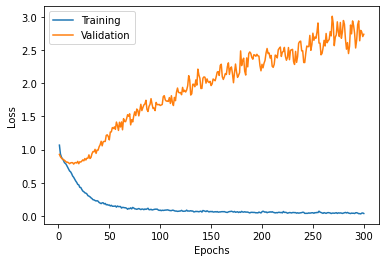

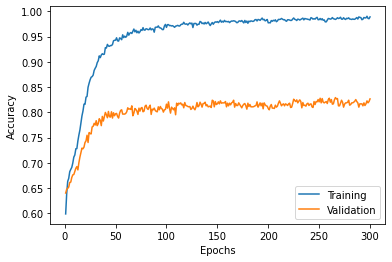

In [ ]:
plot_history(history_dropout)

Dai grafici della history, possiamo notare che l'andamento della accuracy della validation non cresce particolarmente e overfitta ma nel complesso è accettabile.
L'andamento della loss calcolata sul validation set, d'altro canto, inizia dopo poche epoche a crescere senza accennare a migliorare.  

Per questo motivo sono state esplorate anche altre forme di regolarizzazione.

### L1

La seconda tecnica di regolarizzazione utilizzata è L1, tecnica che penalizza maggiormente i pesi più piccoli.

Il metodo `NeuralNetworkL1_L2()` permette di definire una rete come quella base ma con l'aggiunta di regolarizzazione L1 o L2, determinata attraverso il parametro `l1` e applicata a ogni layer eccetto l'ultimo.
Sia i kernel regularizers che i bias regularizers utilizzano uno stesso valore di regolarizzazione che però cambia tra L1 e L2, ed è stato scelto dopo una serie di tentativi.

In [ ]:
def NeuralNetworkL1_L2(act, n_inputs, n_outputs, l1=True): 
  model = Sequential()

  if l1 == True: 
    model.add(Dense(128, activation= act, input_shape=n_inputs, kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)))
    model.add(Dense(64, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)))
    model.add(Dense(32, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)))
    model.add(Dense(16, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)))
    model.add(Dense(n_outputs, activation = "softmax", kernel_initializer=initializer))
  else: 
    model.add(Dense(128, activation= act, input_shape=n_inputs, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
    model.add(Dense(64, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
    model.add(Dense(32, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
    model.add(Dense(16, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
    model.add(Dense(n_outputs, activation = "softmax", kernel_initializer=initializer))

  model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]) 
  
  return model

Viene quindi creata la rete con regolarizzazione L1, usando il metodo `NeuralNetworkL1_L2()`.

In [ ]:
model_l1 = NeuralNetworkL1_L2(act = activation, n_inputs=(dim,), n_outputs = num_classes)

In [ ]:
model_l1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14592     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 25,524
Trainable params: 25,524
Non-trainable params: 0
_________________________________________________________________


La rete viene addestrata con gli stessi parametri della rete base.

In [ ]:
model_l1_history = model_l1.fit(X_train, y_train,
      batch_size = 128,
      epochs = num_epochs,
      verbose = 1,
      validation_data = (X_val, y_val))
K.clear_session()

Epoch 1/300
48/48 [==============================] - 1s 7ms/step - loss: 3.0298 - accuracy: 0.6225 - val_loss: 2.7376 - val_accuracy: 0.6226
Epoch 2/300
48/48 [==============================] - 0s 3ms/step - loss: 2.4884 - accuracy: 0.6491 - val_loss: 2.2917 - val_accuracy: 0.6442
Epoch 3/300
48/48 [==============================] - 0s 3ms/step - loss: 2.0737 - accuracy: 0.6743 - val_loss: 1.9341 - val_accuracy: 0.6514
Epoch 4/300
48/48 [==============================] - 0s 3ms/step - loss: 1.7599 - accuracy: 0.6826 - val_loss: 1.6794 - val_accuracy: 0.6593
Epoch 5/300
48/48 [==============================] - 0s 3ms/step - loss: 1.5272 - accuracy: 0.6898 - val_loss: 1.4947 - val_accuracy: 0.6573
Epoch 6/300
48/48 [==============================] - 0s 3ms/step - loss: 1.3628 - accuracy: 0.6931 - val_loss: 1.3605 - val_accuracy: 0.6612
Epoch 7/300
48/48 [==============================] - 0s 3ms/step - loss: 1.2481 - accuracy: 0.6946 - val_loss: 1.2745 - val_accuracy: 0.6632
Epoch 8/300
4

Risultati ottenuti alla 300esima epoca: 

Set        | Loss  | Accuracy 
-----------|-------|----------
Train      |0.391  |0.961 
Validation |1.377  |0.793 

La validation riporta valori di accuracy e di loss peggiori rispetto a quelli del training set (overfitting). In generale i valori raggiunti con il validation set sono sufficienti ma non eccellenti.

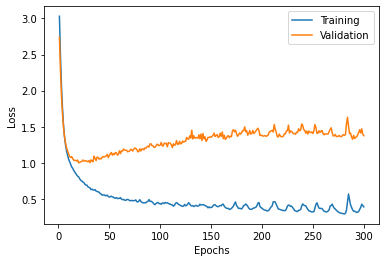

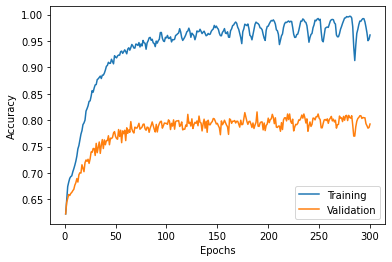

In [ ]:
plot_history(model_l1_history)

I grafici mostrano una situazione di overfitting, in cui la loss del validation set però tende a crescere anziché diminuire. L'accuracy invece si stabilizza su un valore non alto e smette presto di crescere.

##L2

Viene quindi fatto un tentativo con una terza tecnica di regolarizzazione, L2 (Weight decay), metodo che penalizza maggiormente i pesi più grandi.

Viene quindi creato il modello con `NeuralNetworkL1_L2()`.

In [ ]:
model_l2 = NeuralNetworkL1_L2(act = activation, n_inputs=(dim,), n_outputs = num_classes, l1=False)

In [ ]:
model_l2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14592     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 25,524
Trainable params: 25,524
Non-trainable params: 0
_________________________________________________________________


La rete viene addestrata con gli stessi parametri della rete base.

In [ ]:
model_l2_history = model_l2.fit(X_train, y_train,
      batch_size = 128,
      epochs = 300,
      verbose = 1,
      validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
48/48 [==============================] - 1s 8ms/step - loss: 3.2329 - accuracy: 0.6001 - val_loss: 2.6399 - val_accuracy: 0.6429
Epoch 2/300
48/48 [==============================] - 0s 3ms/step - loss: 2.2349 - accuracy: 0.6602 - val_loss: 1.9325 - val_accuracy: 0.6527
Epoch 3/300
48/48 [==============================] - 0s 3ms/step - loss: 1.6734 - accuracy: 0.6753 - val_loss: 1.5196 - val_accuracy: 0.6566
Epoch 4/300
48/48 [==============================] - 0s 3ms/step - loss: 1.3512 - accuracy: 0.6857 - val_loss: 1.2921 - val_accuracy: 0.6566
Epoch 5/300
48/48 [==============================] - 0s 3ms/step - loss: 1.1649 - accuracy: 0.6924 - val_loss: 1.1599 - val_accuracy: 0.6632
Epoch 6/300
48/48 [==============================] - 0s 3ms/step - loss: 1.0547 - accuracy: 0.6959 - val_loss: 1.0754 - val_accuracy: 0.6625
Epoch 7/300
48/48 [==============================] - 0s 3ms/step - loss: 0.9878 - accuracy: 0.7016 - val_loss: 1.0310 - val_accuracy: 0.6691
Epoch 8/300
4

Risultati ottenuti alla 300esima epoca: 

Set        | Loss  | Accuracy 
-----------|-------|----------
Train      |0.354  |0.971 
Validation |1.171  |0.782 

La validation riporta valori di accuracy e di loss peggiori rispetto a quelli del training set (overfitting). In generale i valori raggiunti con il validation set sono appena sufficienti ma non eccellenti.

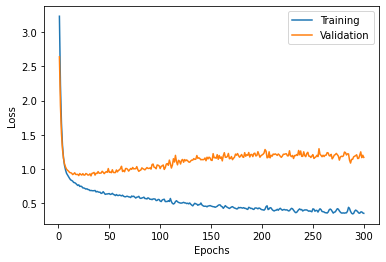

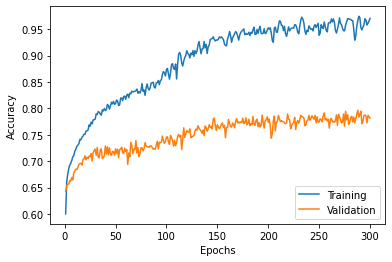

In [ ]:
plot_history(model_l2_history)

I grafici mostrano una situazione di overfitting, in cui la loss del validation set però tende a crescere a diminuire leggermente verso le ultime epoche. L'accuracy invece continua a crescere durante le epoche.

### L2 Dropout

A questo punto, è stato effettuato un tentativo combinando le tecniche di Dropout e L2, per vedere se insieme riuscissero a ottenere risultati migliori. 

Tra L1 e L2 è stata scelta la seconda perché, osservando i grafici, l'andamento della history era migliore.

Il metodo `NeuralNetworkL2_drop()` consente di creare una rete neurale uguale alla rete base ma che combini le tecniche di Dropout e regolarizzazione L2 (quest'ultima sempre con valore 0.01).

In [ ]:
def NeuralNetworkL2_drop(act, n_inputs, n_outputs, v): 
  model = Sequential()
  model.add(Dense(128, activation= act, input_shape=n_inputs,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
  model.add(Dense(64, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(v[0]))
  model.add(Dense(32, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(v[1]))
  model.add(Dense(16, activation = act, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(v[2]))
  model.add(Dense(n_outputs, activation = "softmax", kernel_initializer=initializer))

  model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]) 
  
  return model

Per il Dropout sono state scelte percentuali più basse in modo da non incidere troppo con la regolarizzazione sul modello.

Nel secondo, terzo e quarto strato viene quindi rimosso il 10% dei neuroni.

In [ ]:
model_l2_drop = NeuralNetworkL2_drop(act = activation, n_inputs=(dim,), n_outputs = num_classes, v = [0.1, 0.1, 0.1])

In [ ]:
model_l2_drop.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14592     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

La rete viene addestrata con gli stessi parametri della rete base.

In [ ]:
model_l2_drop_history = model_l2_drop.fit(X_train, y_train,
      batch_size = 128,
      epochs = num_epochs,
      verbose = 1,
      validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
48/48 [==============================] - 1s 7ms/step - loss: 3.3767 - accuracy: 0.5754 - val_loss: 2.7572 - val_accuracy: 0.6213
Epoch 2/300
48/48 [==============================] - 0s 3ms/step - loss: 2.3644 - accuracy: 0.6455 - val_loss: 2.0216 - val_accuracy: 0.6468
Epoch 3/300
48/48 [==============================] - 0s 3ms/step - loss: 1.7738 - accuracy: 0.6630 - val_loss: 1.5752 - val_accuracy: 0.6553
Epoch 4/300
48/48 [==============================] - 0s 3ms/step - loss: 1.4182 - accuracy: 0.6759 - val_loss: 1.3219 - val_accuracy: 0.6547
Epoch 5/300
48/48 [==============================] - 0s 4ms/step - loss: 1.2102 - accuracy: 0.6833 - val_loss: 1.1748 - val_accuracy: 0.6619
Epoch 6/300
48/48 [==============================] - 0s 3ms/step - loss: 1.0905 - accuracy: 0.6879 - val_loss: 1.0790 - val_accuracy: 0.6632
Epoch 7/300
48/48 [==============================] - 0s 3ms/step - loss: 1.0190 - accuracy: 0.6942 - val_loss: 1.0306 - val_accuracy: 0.6671
Epoch 8/300
4

Risultati ottenuti alla 300esima epoca: 

Set        | Loss  | Accuracy 
-----------|-------|----------
Train      |0.498  |0.910 
Validation |1.208  |0.764 

Come possiamo notare, i risultati risultano essere molto simili a quelli precedentemente ottenuti con L2, ma la loss sul validation set risulta migliore rispetto a quella ottenuta con solo Dropout.

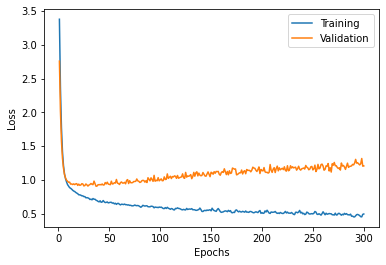

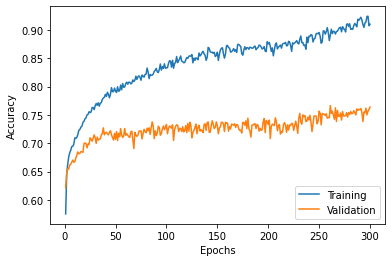

In [ ]:
plot_history(model_l2_drop_history)

Anche per quanto riguarda l'andamento della history, valgono osservazioni molto simili a quelle fatte per i grafici di L2. Notiamo però che con Dropout la loss calcolata sul validation set tende sempre a crescere anche nelle ultime epoche.

## Early Stopping

La quarta tecnica di regolarizzazione utilizzata è Early Stopping, che consente di ritornare al miglior modello ottenuto durante la fase di training se esso non coincide con l'ultimo ottenuto.

La tecnica Early Stopping viene aggiunta ai due migliori modelli ottenuti finora: quello con L2 e quello con L2 e Dropout.

Al fine di applicare Early Stopping è necessario definire `early_stopping` che specifica quale variabile si vuole monitorare (nel nostro caso la validation loss) e quanta `patience` si vuole avere prima di decretare che il modello non stia migliorando. 
Nel nostro caso, dal momento che gli andamenti della loss riusltano essere molto oscillanti, abbiamo fissato una `patiente` alta: vengono attese 70 epoche prima di decretare che il modello non sta effettivamente migliorando.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=70)

### L2 Early Stopping

Viene quindi applicato Early Stopping al modello ottenuto con L2. 



Per applicarlo viene definito un `ModelCheckpoint` al fine di salvare il miglior modello ottenuto durante l'addestramento e poterlo utilizzare in seguito per effettuare le predizioni. 

Il modello migliore viene scelto in base ai valori assunti dalla variabile validation accuracy e salvato in `best_l2_es.he`. 

In [ ]:
mc = ModelCheckpoint('best_l2_es.h5', monitor='val_accuracy', 
                     mode='auto', verbose=1, save_best_only=True)

Dal momento che Early Stopping viene applicato in fase di addestramento, viene utilizzato il modello già creato con L2, `model_l2` e la rete viene addestrata usando gli stessi parametri della rete base con l'aggiunta di `callbacks` per effettuare l'Early Stopping.

In [ ]:
model_l2_es_history = model_l2.fit(X_train, y_train,
      batch_size = 128,
      epochs = 300,
      verbose = 1,
      callbacks=[early_stopping, mc],
      validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
46/48 [===========================>..] - ETA: 0s - loss: 3.1659 - accuracy: 0.6077
Epoch 00001: val_accuracy improved from -inf to 0.63571, saving model to best_l2_es.h5
48/48 [==============================] - 1s 8ms/step - loss: 3.1410 - accuracy: 0.6104 - val_loss: 2.5424 - val_accuracy: 0.6357
Epoch 2/300
45/48 [===========================>..] - ETA: 0s - loss: 2.1560 - accuracy: 0.6571
Epoch 00002: val_accuracy improved from 0.63571 to 0.65533, saving model to best_l2_es.h5
48/48 [==============================] - 0s 4ms/step - loss: 2.1369 - accuracy: 0.6571 - val_loss: 1.8261 - val_accuracy: 0.6553
Epoch 3/300
45/48 [===========================>..] - ETA: 0s - loss: 1.5851 - accuracy: 0.6743
Epoch 00003: val_accuracy improved from 0.65533 to 0.65795, saving model to best_l2_es.h5
48/48 [==============================] - 0s 4ms/step - loss: 1.5831 - accuracy: 0.6710 - val_loss: 1.4353 - val_accuracy: 0.6579
Epoch 4/300
45/48 [===========================>..] - ETA: 0s 

Early Stopping porta l'addestramento a interrompersi alla 96esima epoca.

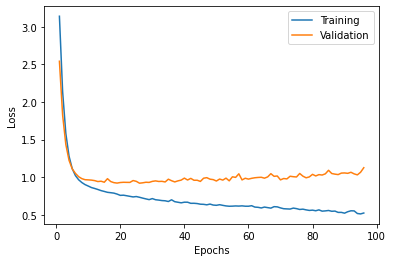

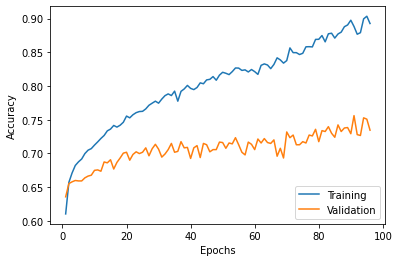

In [ ]:
n_epochs = len(model_l2_es_history.history['loss'])
x_plot = list(range(1,n_epochs+1))
plot_history(model_l2_es_history)

Infatti come possiamo vedere da parecchie epoche la loss calcolata sul validation set stava continuando a crescere.

Viene quindi caricato il modello migliore, `best_l2_es`.

In [ ]:
best_l2_es = load_model('best_l2_es.h5')

E vengono valutati i valori di accuracy e loss per training e validation set.

In [ ]:
train_loss, train_acc = best_l2_es.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = best_l2_es.evaluate(X_val, y_val, verbose=0)
print('Train loss: %.3f, Train accuracy: %.3f' % (train_loss, train_acc))
print('Validation loss: %.3f, Validation accuracy: %.3f' % (val_loss, val_acc))

Train loss: 0.516, Train accuracy: 0.897
Validation loss: 1.052, Validation accuracy: 0.756


Confrontando con i valori di accuracy e loss ottenuti con il modello L2 senza Early Stopping notiamo che i valori ottenuti con il train set sono leggermente peggiori ma comunque molto buoni, mentre la loss ottenuta con il validation set è migliorata e l'accuracy ottenuta con il validation set leggermente peggiorata.
Nel complesso, non sembrano esserci sostanziali differenze tra i due modelli.

### L2 Dropout Early Stopping

L'altro modello a cui viene applicato Early Stopping è quello ottenuto con L2 e Dropout.

Viene definito un `ModelCheckpoint`, con gli stessi parametri del precendente, che salverò il modello migliore in `best_l2_drop_es.he`. 

In [ ]:
mc = ModelCheckpoint('best_l2_drop_es.h5', monitor='val_accuracy', 
                     mode='auto', verbose=1, save_best_only=True)

Dal momento che Early Stopping viene applicato in fase di addestramento, viene utilizzato il modello già creato con L2 e Dropout, `model_l2_drop` e la rete viene addestrata usando gli stessi parametri della rete base con l'aggiunta di `callbacks` per effettuare l'Early Stopping.

In [ ]:
model_l2_drop_es_history = model_l2_drop.fit(X_train, y_train,
                                                batch_size = 128,
                                                epochs = 300,
                                                verbose = 1,
                                                callbacks = [early_stopping, mc],
                                                validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
41/48 [========================>.....] - ETA: 0s - loss: 0.4825 - accuracy: 0.9139
Epoch 00001: val_accuracy improved from -inf to 0.76063, saving model to best_l2_drop_es.h5
48/48 [==============================] - 0s 5ms/step - loss: 0.4828 - accuracy: 0.9142 - val_loss: 1.2268 - val_accuracy: 0.7606
Epoch 2/300
38/48 [======================>.......] - ETA: 0s - loss: 0.4636 - accuracy: 0.9204
Epoch 00002: val_accuracy did not improve from 0.76063
48/48 [==============================] - 0s 4ms/step - loss: 0.4718 - accuracy: 0.9155 - val_loss: 1.2306 - val_accuracy: 0.7606
Epoch 3/300
44/48 [==========================>...] - ETA: 0s - loss: 0.4859 - accuracy: 0.9118
Epoch 00003: val_accuracy did not improve from 0.76063
48/48 [==============================] - 0s 3ms/step - loss: 0.4875 - accuracy: 0.9104 - val_loss: 1.2986 - val_accuracy: 0.7449
Epoch 4/300
38/48 [======================>.......] - ETA: 0s - loss: 0.4766 - accuracy: 0.9167
Epoch 00004: val_accuracy did n

Early Stopping porta l'addestramento a interrompersi alla 165esima epoca.

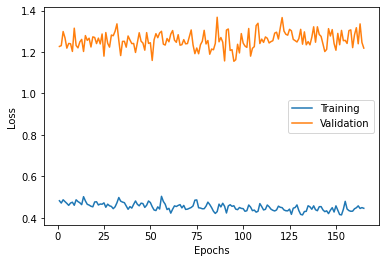

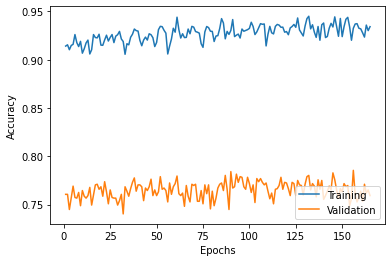

In [ ]:
n_epochs = len(model_l2_drop_es_history.history['loss'])
x_plot = list(range(1,n_epochs+1))
plot_history(model_l2_drop_es_history)

All'apparenza stazionaria, da 70 epoche la loss del validation set non stava più descrescendo. La particolarità di questo addrestramento è che neanche dai risultati ottenuti sul training set notiamo particolari miglioramenti nel corso delle epoche.

Viene caricato il modello migliore, `best_l2_drop_es`.

In [ ]:
best_l2_drop_es = load_model('best_l2_drop_es.h5')

E vengono valutati i valori di accuracy e loss per training e validation set.

In [ ]:
train_loss, train_acc = best_l2_drop_es.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = best_l2_drop_es.evaluate(X_val, y_val, verbose=0)
print('Train loss: %.3f, Train accuracy: %.3f' % (train_loss, train_acc))
print('Validation loss: %.3f, Validation accuracy: %.3f' % (val_loss, val_acc))

Train loss: 0.387, Train accuracy: 0.957
Validation loss: 1.241, Validation accuracy: 0.785


Confrontando con i valori di accuracy e loss ottenuti con il modello L2 e Dropout senza Early Stopping notiamo che i valori ottenuti con il train set sono ora leggermente migliori, mentre la loss ottenuta con il validation set è molto simile e l'accuracy ottenuta con il validation set è migliorata.
Nel complesso, anche in questo caso le differenze sono minime.

Confrontando invece con i risultati ottenuti con L2 e Early stopping notiamo che per quanto riguarda la validation, l'accuracy è migliore con il Dropout, mentre la loss peggiore. 

##Class Weight

Al fine di migliorare i risultati ottenuti e gestire il fatto che il dataset utilizzato ha una variabile target con distribuzione sbilanciata verso la classe 4, è stato fatto un tentativo di class weighting. 

`compute_class_weight` di Keras, permette infatti di assegnare un nuovo peso alle classi del target, in modo che i loro nuovi pesi bilancino le loro occorrenze.

In [ ]:
class_weight = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(np.argmax(y_train, axis=1)), 
                                        y = np.argmax(y_train, axis=1))
class_weight = dict(zip(np.unique(np.argmax(y_train, axis=1)), class_weight)),
class_weight = class_weight[0]
display(class_weight)

{0: 3.267094017094017,
 1: 1.4960861056751467,
 2: 2.011842105263158,
 3: 0.39549922400413867}

Come si può notare, per esempio, la classe 0, che ha meno occorrenze di tutte, è quella a cui è stato assegnato il peso più alto.

### L2 Early Stopping Class Weight

Viene quindi applicato Class Weight al modello ottenuto con L2, `model_l2`, e durante l'addestramento verrà applicato anche Early Stopping.

Come visto precedentemente il modello migliore verrà salvato grazie a `ModelCheckpoint` in `best_l2_es_cw.he`. 

In [ ]:
mc = ModelCheckpoint('best_l2_es_cw.h5', monitor='val_accuracy', 
                     mode='auto', verbose=1, save_best_only=True)

La rete viene addestrata usando gli stessi parametri della rete base con l'aggiunta di `callbacks` per effettuare l'Early Stopping e di `class_weight` per effettuare il class weighting.

In [ ]:
model_l2_es_cw_history = model_l2.fit(X_train, y_train,
      batch_size = 128,
      epochs = 300,
      verbose = 1,
      class_weight = class_weight,
      callbacks = [early_stopping, mc],
      validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
34/48 [====================>.........] - ETA: 0s - loss: 0.8020 - accuracy: 0.8355
Epoch 00001: val_accuracy improved from -inf to 0.66252, saving model to best_l2_es_cw.h5
48/48 [==============================] - 1s 6ms/step - loss: 0.8252 - accuracy: 0.8233 - val_loss: 1.2589 - val_accuracy: 0.6625
Epoch 2/300
34/48 [====================>.........] - ETA: 0s - loss: 0.8194 - accuracy: 0.8173
Epoch 00002: val_accuracy improved from 0.66252 to 0.67691, saving model to best_l2_es_cw.h5
48/48 [==============================] - 0s 4ms/step - loss: 0.8264 - accuracy: 0.8112 - val_loss: 1.1869 - val_accuracy: 0.6769
Epoch 3/300
35/48 [====================>.........] - ETA: 0s - loss: 0.7720 - accuracy: 0.8330
Epoch 00003: val_accuracy did not improve from 0.67691
48/48 [==============================] - 0s 4ms/step - loss: 0.7783 - accuracy: 0.8316 - val_loss: 1.2013 - val_accuracy: 0.6730
Epoch 4/300
35/48 [====================>.........] - ETA: 0s - loss: 0.7230 - accuracy: 0.

Early Stopping porta l'addestramento a interrompersi alla 72esima epoca.

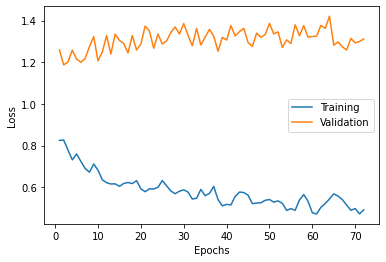

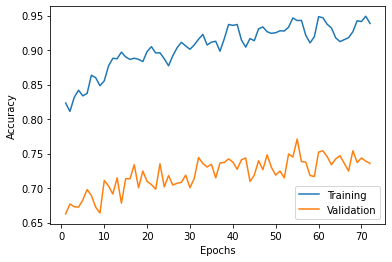

In [ ]:
n_epochs = len(model_l2_es_cw_history.history['loss'])
x_plot = list(range(1,n_epochs+1))
plot_history(model_l2_es_cw_history)

Dai grafici possiamo notare una crescita della validation accuracy e un'iniziale crescita, seguita da una decrescita della validation loss (motivo per cui l'addestramento si interrompe dopo così poche epoche). 

Viene quindi caricato il modello migliore, `best_l2_es_cw`.

In [ ]:
best_l2_es_cw = load_model('best_l2_es_cw.h5')

E vengono valutati i valori di accuracy e loss per training e validation set.

In [ ]:
train_loss, train_acc = best_l2_es_cw.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = best_l2_es_cw.evaluate(X_val, y_val, verbose=0)
print('Train loss: %.3f, Train accuracy: %.3f' % (train_loss, train_acc))
print('Validation loss: %.3f, Validation accuracy: %.3f' % (val_loss, val_acc))

Train loss: 0.449, Train accuracy: 0.967
Validation loss: 1.290, Validation accuracy: 0.771


Confrontando con i valori di accuracy e loss ottenuti con il modello L2 Early Stopping senza Class Weight, notiamo che sul training set ora otteniamo valori migliori, mentre sul validation set la loss è peggiorata mentre l'accuracy è migliorata. 
Come nei casi precedenti, i risultati dei due modelli confrontati non distano poi molto fra loro.

### L2 Dropout Early Stopping Class Weight

L'ultimo tentativo effettuato è quello in cui Class Weight è stato applicato al modello ottenuto con L2 e Dropout, `model_l2_drop`.

Durante l'addestramento viene comunque applicato Early Stopping quindi ancora una volta il modello migliore verrà salvato grazie a `ModelCheckpoint` in `best_l2_drop_es_cw.he`. 

In [ ]:
mc = ModelCheckpoint('best_l2_drop_es_cw.h5', monitor='val_accuracy', 
                     mode='auto', verbose=1, save_best_only=True)

La rete viene addestrata usando gli stessi parametri della rete base con l'aggiunta di `callbacks` per effettuare l'Early Stopping e di `class_weight` per effettuare il class weighting.

In [ ]:
model_l2_drop_es_cw_history = model_l2_drop.fit(X_train, y_train,
      batch_size = 128,
      epochs = 300,
      verbose = 1,
      class_weight = class_weight,
      callbacks = [early_stopping, mc],
      validation_data = (X_val, y_val))

K.clear_session()

Epoch 1/300
33/48 [===================>..........] - ETA: 0s - loss: 0.6729 - accuracy: 0.8757
Epoch 00001: val_accuracy improved from -inf to 0.67757, saving model to best_l2_drop_es_cw.h5
48/48 [==============================] - 1s 6ms/step - loss: 0.7011 - accuracy: 0.8661 - val_loss: 1.5243 - val_accuracy: 0.6776
Epoch 2/300
47/48 [============================>.] - ETA: 0s - loss: 0.7345 - accuracy: 0.8531
Epoch 00002: val_accuracy improved from 0.67757 to 0.71288, saving model to best_l2_drop_es_cw.h5
48/48 [==============================] - 0s 5ms/step - loss: 0.7342 - accuracy: 0.8535 - val_loss: 1.3023 - val_accuracy: 0.7129
Epoch 3/300
33/48 [===================>..........] - ETA: 0s - loss: 0.6696 - accuracy: 0.8778
Epoch 00003: val_accuracy did not improve from 0.71288
48/48 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.8685 - val_loss: 1.2657 - val_accuracy: 0.7070
Epoch 4/300
34/48 [====================>.........] - ETA: 0s - loss: 0.6428 - ac

Early Stopping porta l'addestramento a interrompersi alla 74esima epoca.

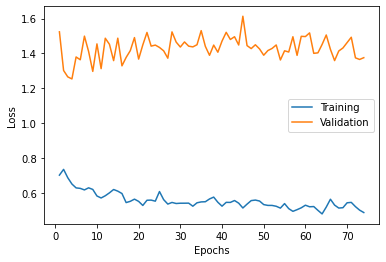

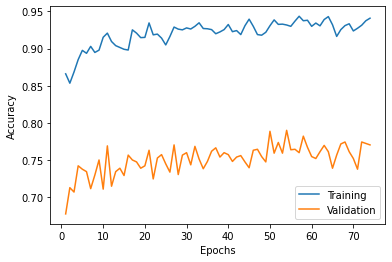

In [ ]:
n_epochs = len(model_l2_drop_es_cw_history.history['loss'])
x_plot = list(range(1,n_epochs+1))
plot_history(model_l2_drop_es_cw_history)

Entrambi loss e accuracy risultano essere oscillanti ma si può notare come la validation loss in un primo momento cresce, per poi descrere. Non sono comunque più stati raggiunti gli iniziali risultati, motivo per cui dopo 70 epoche di non miglioramento, l'addestramento è stato interrotto.

Viene caricato il modello migliore, `best_l2_drop_es_cw`.

In [ ]:
best_l2_drop_es_cw = load_model('best_l2_drop_es_cw.h5')

E vengono valutati i valori di accuracy e loss per training e validation set.

In [ ]:
train_loss, train_acc = best_l2_drop_es_cw.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = best_l2_drop_es_cw.evaluate(X_val, y_val, verbose=0)
print('Train loss: %.3f, Train accuracy: %.3f' % (train_loss, train_acc))
print('Validation loss: %.3f, Validation accuracy: %.3f' % (val_loss, val_acc))

Train loss: 0.405, Train accuracy: 0.971
Validation loss: 1.363, Validation accuracy: 0.790


Confrontando con i valori di accuracy e loss ottenuti con il modello con L2, Dropout e Early Stopping ma senza Class Weight notiamo che la training loss è leggermente peggiorata, mentre la training accuracy leggermente migliorata. 
Stessa situazione riscontriamo anche per accuracy e loss del validation set. 
Le differenze risultano però essere minime.

Confrontando invece con i risultati ottenuti con il modello con L2 e Early Stopping, notiamo che per quanto riguarda il training, ora otteniamo risultati migliori, mentre per la validation solo l'accuracy è di poco migliore.

# Evaluation Metrics

Vengono ora valutate alcune misure di performance su validation e test set per i modelli che abbiamo selezionato come migliori: L2, L2-EarlyStopping e L2-EarlyStopping-ClassWeight.

## Metodi implementati per le evaluation metrics

Il metodo `conf_matrix()` consente di creare e visualizzare una matrice di confusione per variabili target con più di due classi. Il metodo restituisce la matrice di confusione e le predizioni per la variabile target effettuate usando i dati passati in input.

In [ ]:
def conf_matrix(X, y, model): 
  print("Confusion Matrix:")
  y_pred = model.predict(X)
  y_pred_bool = (y_pred > 0.5)
  matrix = multilabel_confusion_matrix(y_true=y, y_pred=y_pred_bool)
  display(matrix)
  return y_pred, y_pred_bool, matrix

Il metodo `conf_matrix_plot()` consente di visualizzare graficamente una matrice di confusione per variabili target di 4 classi.

In [ ]:
def conf_matrix_plot(y, y_pred_bool): 
  f, axes = plt.subplots(2, 2, figsize=(26, 20))
  axes = axes.ravel()
  for i in range(4):
      disp = ConfusionMatrixDisplay(confusion_matrix(y[:, i],
                                                    y_pred_bool[:, i]),
                                    display_labels=["sbagliata", i])
      disp.plot(ax=axes[i], values_format='.4g')
      disp.ax_.set_title(f'class {i}')
      if i<10:
          disp.ax_.set_xlabel('Predicted label')
      if i%5!=0:
          disp.ax_.set_ylabel('True label')
      disp.im_.colorbar.remove()

  plt.subplots_adjust(wspace=0.15, hspace=0.3)
  f.colorbar(disp.im_, ax=axes)
  plt.show()

Il metodo `evaluation_metrics()` consente di calcolare l'accuratezza su un determinato set di dati e per ogni classe, i valori di alcune evaluation metrics.

In [ ]:
def evaluation_metrics(X, y, y_pred, model): 
  score = model.evaluate(X, y, verbose=0)
  print("Loss:", score[0])
  print("Accuracy:", score[1])
  y_classes = y_pred.argmax(axis=-1)
  y = np.argmax(y, axis=1) #from one hot to numeric label
  print("\n", classification_report(y_classes, y))

## Performance L2

Vengono valutate le performance del modello con regolarizzazione L2.

### Validation set performance

In [ ]:
y_val_pred, y_val_pred_bool, matrix = conf_matrix(X_val, y_val, model=model_l2)

Confusion Matrix:


array([[[1382,   24],
        [  54,   69]],

       [[1171,   94],
        [ 113,  151]],

       [[1150,  184],
        [  87,  108]],

       [[ 506,   76],
        [ 155,  792]]])

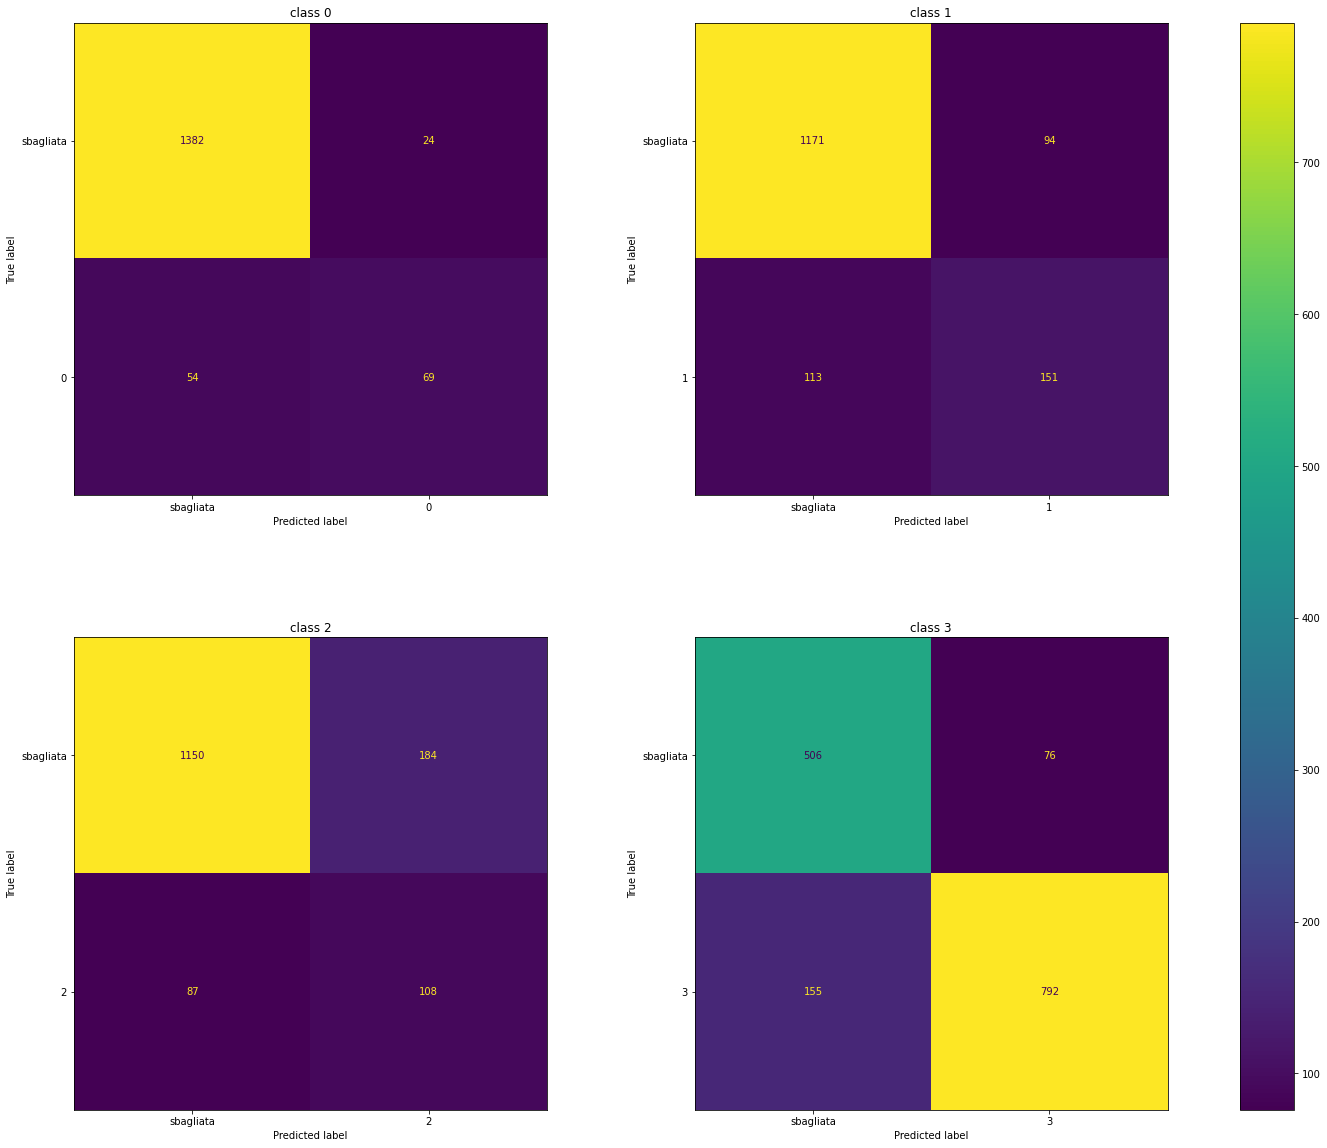

In [ ]:
conf_matrix_plot(y=y_val, y_pred_bool=y_val_pred_bool)

Come possiamo notare, il modello con L2 riconosce molto bene la classe 3, mentre fatica molto a riconoscere le altre.
Riscontriamo anche molti falsi positivi nella classe 2 (più che nelle altre classi).

In [ ]:
evaluation_metrics(X=X_val, y=y_val, y_pred=y_val_pred, model=model_l2)

Loss: 1.3114008903503418
Accuracy: 0.7357749938964844

               precision    recall  f1-score   support

           0       0.56      0.74      0.64        93
           1       0.58      0.60      0.59       253
           2       0.56      0.36      0.44       306
           3       0.84      0.91      0.87       877

    accuracy                           0.74      1529
   macro avg       0.63      0.65      0.63      1529
weighted avg       0.72      0.74      0.72      1529



Loss e accuracy risultano buone ma non ottimali. 
Notiamo inoltre che la classe predetta meno correttamente è la classe 2, con un pessimo valore di recall (0.36). Noriamo inoltre che per le prime tre classi anche i valori di precision sono molto scarsi.

### Test set performance

In [ ]:
y_test_pred, y_test_pred_bool, matrix = conf_matrix(X_test, y_test, model=model_l2)

Confusion Matrix:


array([[[1713,   35],
        [  59,  105]],

       [[1475,  126],
        [ 128,  183]],

       [[1437,  221],
        [ 113,  141]],

       [[ 618,  111],
        [ 221,  962]]])

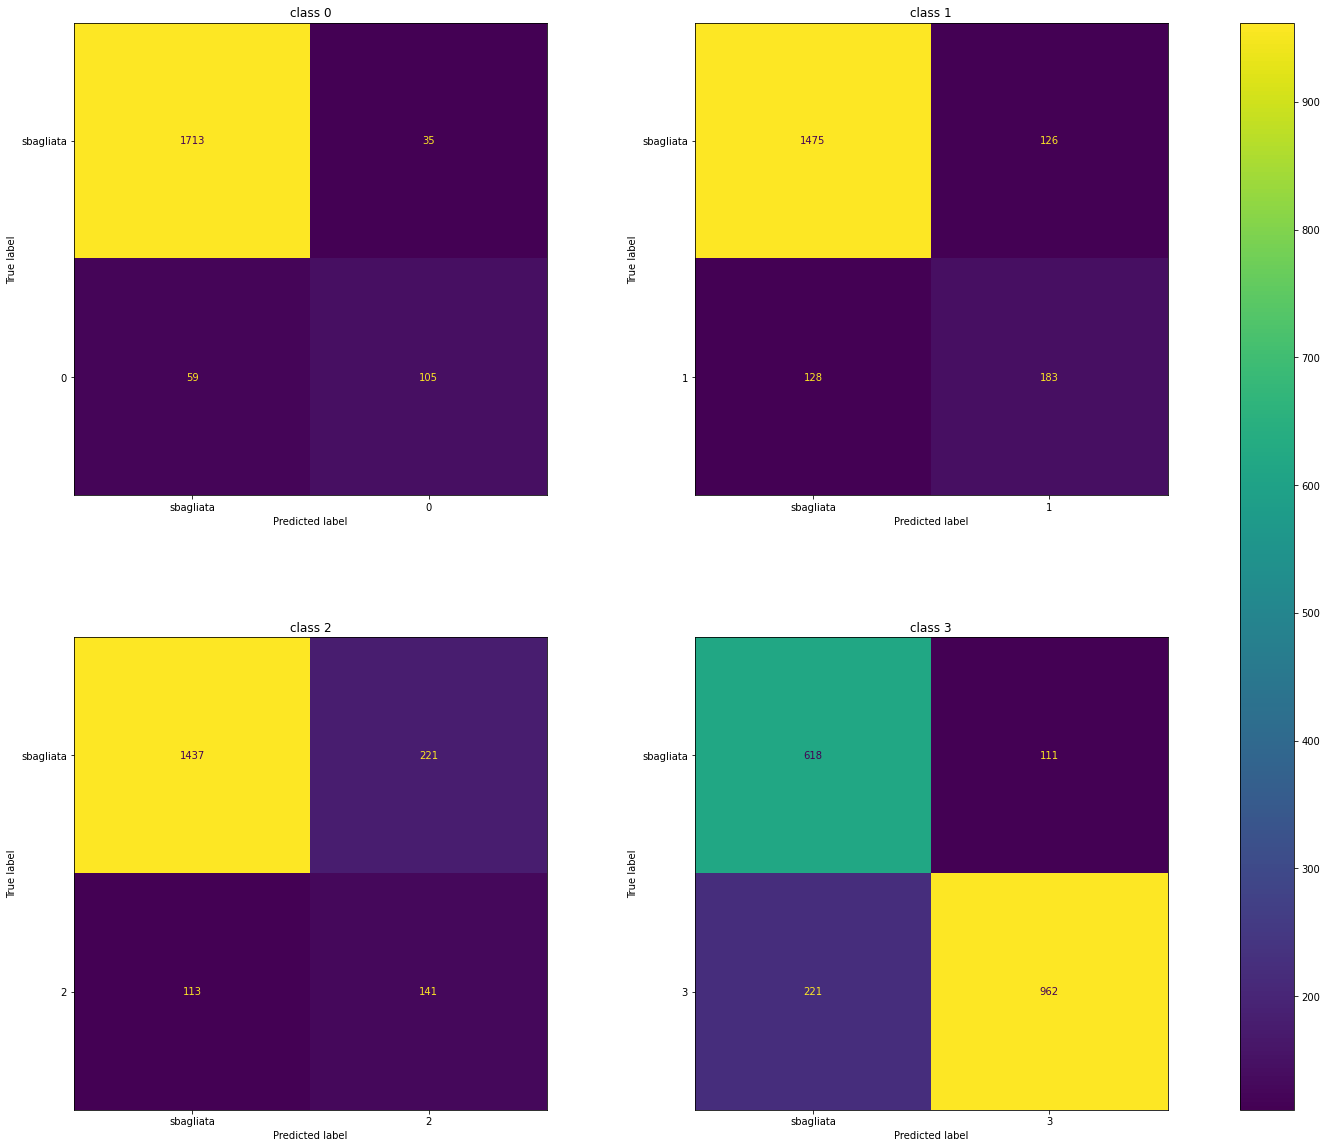

In [ ]:
conf_matrix_plot(y=y_test, y_pred_bool=y_test_pred_bool)

Anche utilizatto il test set, vediamo che il modello con L2 riconosce molto bene la classe 3, mentre fatica molto a riconoscere le altre.
Riscontriamo ancora molti falsi positivi nella classe 2 (più che nelle altre classi).

In [ ]:
evaluation_metrics(X=X_test, y=y_test, y_pred=y_test_pred, model=model_l2)

Loss: 1.5868066549301147
Accuracy: 0.7316945791244507

               precision    recall  f1-score   support

           0       0.64      0.75      0.69       140
           1       0.60      0.58      0.59       318
           2       0.56      0.38      0.45       376
           3       0.82      0.90      0.85      1078

    accuracy                           0.73      1912
   macro avg       0.65      0.65      0.65      1912
weighted avg       0.72      0.73      0.72      1912



La loss calcolata sul test set è leggermente peggiore rispetto a quella della validation. 
La classe 2 ha una recall leggermente migliore, ma ancora molto scarsa.
Notiamo però un miglioramento nella precision che ora raggiunge per 3 classi almeno lo 0.60. 


## Performance L2 Early Stopping

Il secondo modello selezionato è il modello con regolarizzazione L2 e Early Stopping.

### Validation set performance

In [ ]:
y_val_pred, y_val_pred_bool, matrix = conf_matrix(X_val, y_val, model=best_l2_es)

Confusion Matrix:


array([[[1390,   16],
        [  84,   39]],

       [[1162,  103],
        [ 124,  140]],

       [[1243,   91],
        [ 123,   72]],

       [[ 469,  113],
        [  73,  874]]])

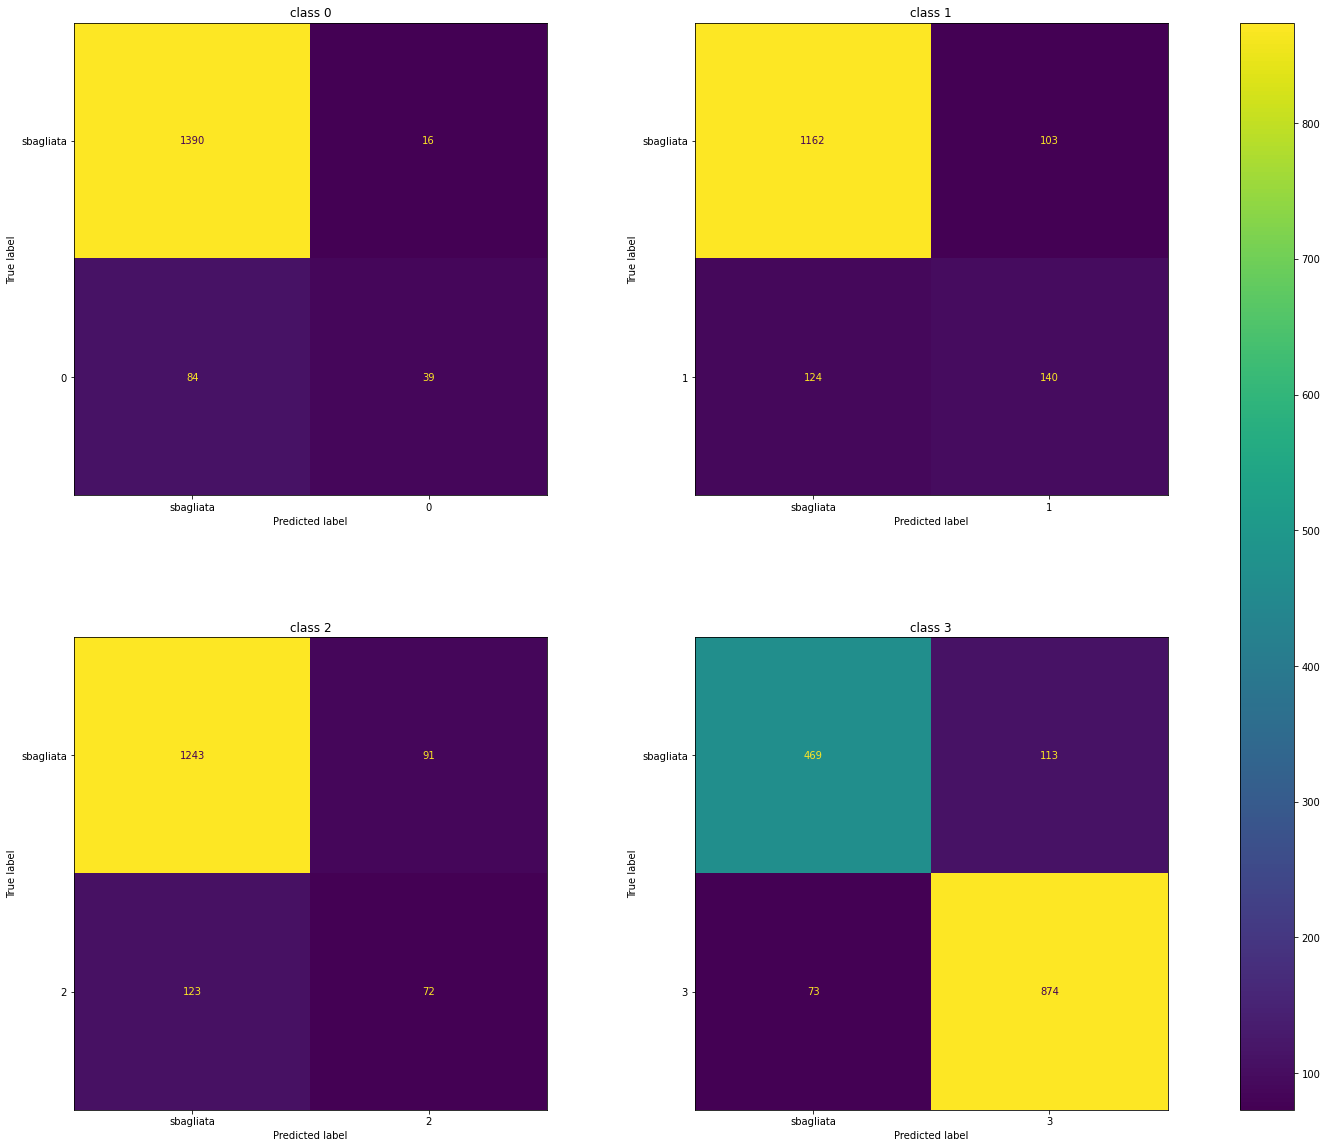

In [ ]:
conf_matrix_plot(y=y_val, y_pred_bool=y_val_pred_bool)

Il modello con L2 e Early Stopping riconosce molto bene la classe 3. Presenta però molti falsi negativi nelle classi 0 e 2, che superano in entrambi i casi il numero di veri positivi.

In [ ]:
evaluation_metrics(X=X_val, y=y_val, y_pred=y_val_pred, model=best_l2_es)

Loss: 1.0516184568405151
Accuracy: 0.7560496926307678

               precision    recall  f1-score   support

           0       0.32      0.68      0.43        57
           1       0.57      0.57      0.57       263
           2       0.45      0.41      0.43       212
           3       0.93      0.88      0.91       997

    accuracy                           0.76      1529
   macro avg       0.57      0.64      0.58      1529
weighted avg       0.78      0.76      0.76      1529



Loss e accuracy sul validation set riportano valori migliori rispetto a quelli ottenuti con il modello L2. 
Benché migliore, un'accuracy del 76% non è ancora soddisfacente.
Notiamo che rispetto a prima la classe 0 viene ora predetta molto male (pessima precision). Inoltre, si hanno ancora problemi nella predizione della classe 2, seguia dalla 1. L'unica predetta adeguatamente rimane sempre la 3 (ciò è dovuto a un supporto più grande). 

### Test set performance

In [ ]:
y_test_pred, y_test_pred_bool, matrix = conf_matrix(X_test, y_test, model=best_l2_es)

Confusion Matrix:


array([[[1717,   31],
        [ 110,   54]],

       [[1443,  158],
        [ 161,  150]],

       [[1530,  128],
        [ 150,  104]],

       [[ 591,  138],
        [ 139, 1044]]])

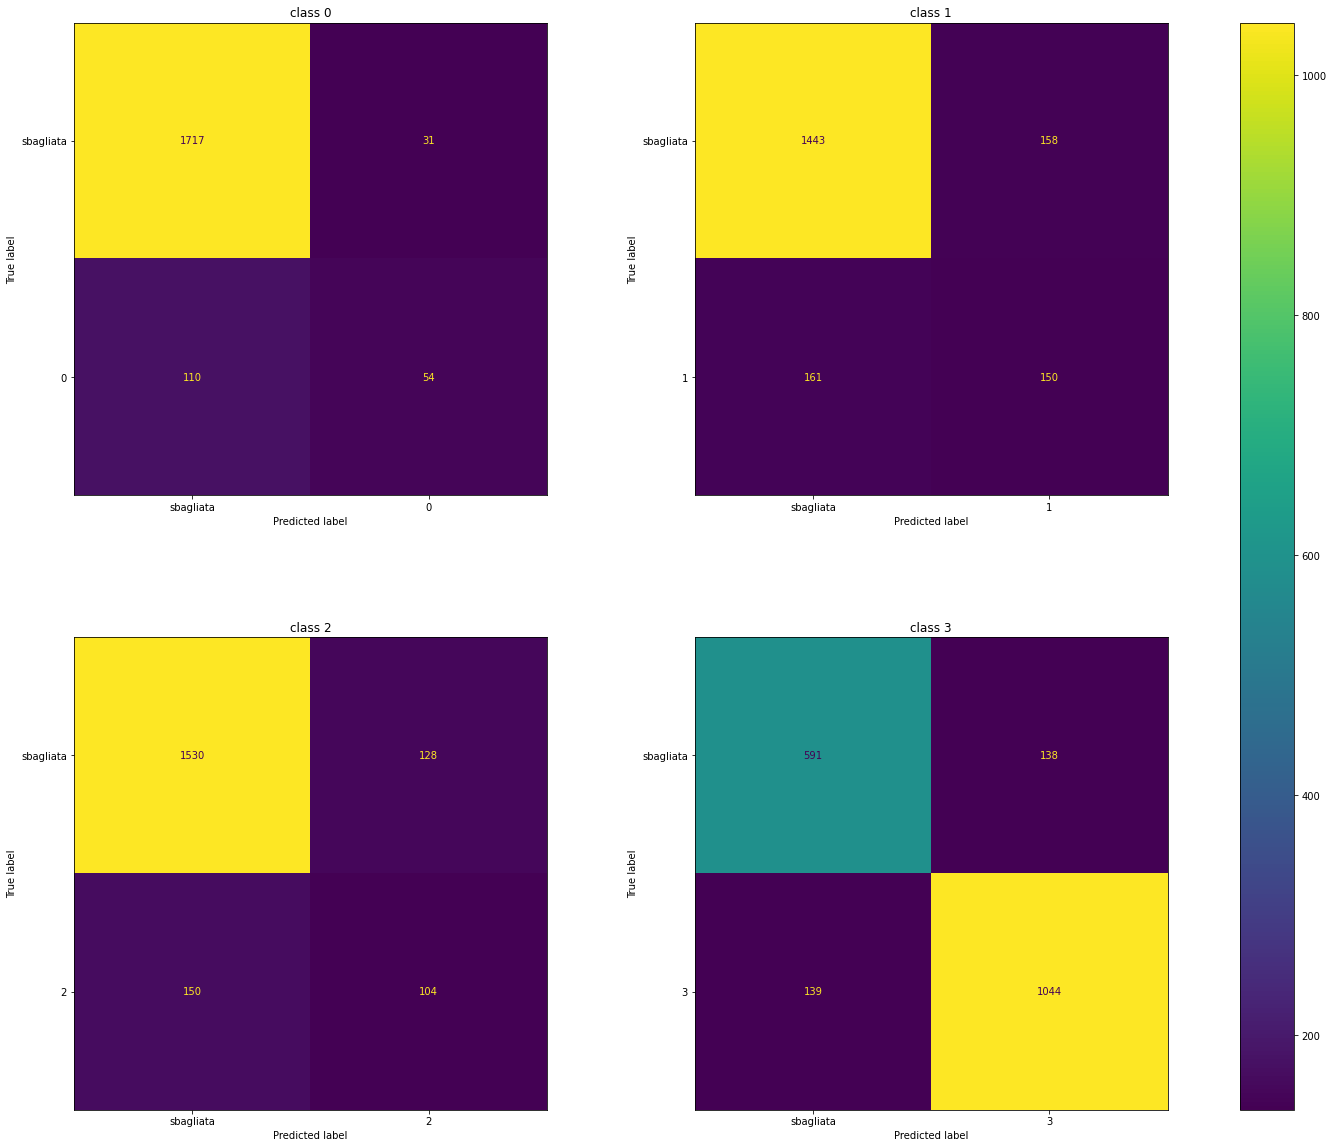

In [ ]:
conf_matrix_plot(y=y_test, y_pred_bool=y_test_pred_bool)

Le matrici di confusione ottenute con il test set risultano essere molto simili a quelle ottenute con il validation set. ad eccezione che ora anche nella classe 1 i falsi negativi superano i vero positivi.

In [ ]:
evaluation_metrics(X=X_test, y=y_test, y_pred=y_test_pred, model=best_l2_es)

Loss: 1.2024909257888794
Accuracy: 0.7285565137863159

               precision    recall  f1-score   support

           0       0.34      0.63      0.44        87
           1       0.53      0.49      0.51       335
           2       0.46      0.41      0.43       285
           3       0.89      0.88      0.89      1205

    accuracy                           0.73      1912
   macro avg       0.55      0.60      0.57      1912
weighted avg       0.74      0.73      0.73      1912



Loss e accuracy riportano un peggiormento quando calcolate sul test set rispetto al validation set. Al di là di piccole variazioni nei valori di precision e recall delle varie classi non si registrano particolari differenze.

## Performance L2 Early Stopping Class Weight

Il terzo modello analizzato è il modello con regolarizzazione L2, Early Stopping e Class Weight.

### Validation set performance 

In [ ]:
y_val_pred, y_val_pred_bool, matrix = conf_matrix(X_val, y_val, model=best_l2_es_cw)

Confusion Matrix:


array([[[1392,   14],
        [  61,   62]],

       [[1167,   98],
        [  91,  173]],

       [[1184,  150],
        [  76,  119]],

       [[ 513,   69],
        [ 126,  821]]])

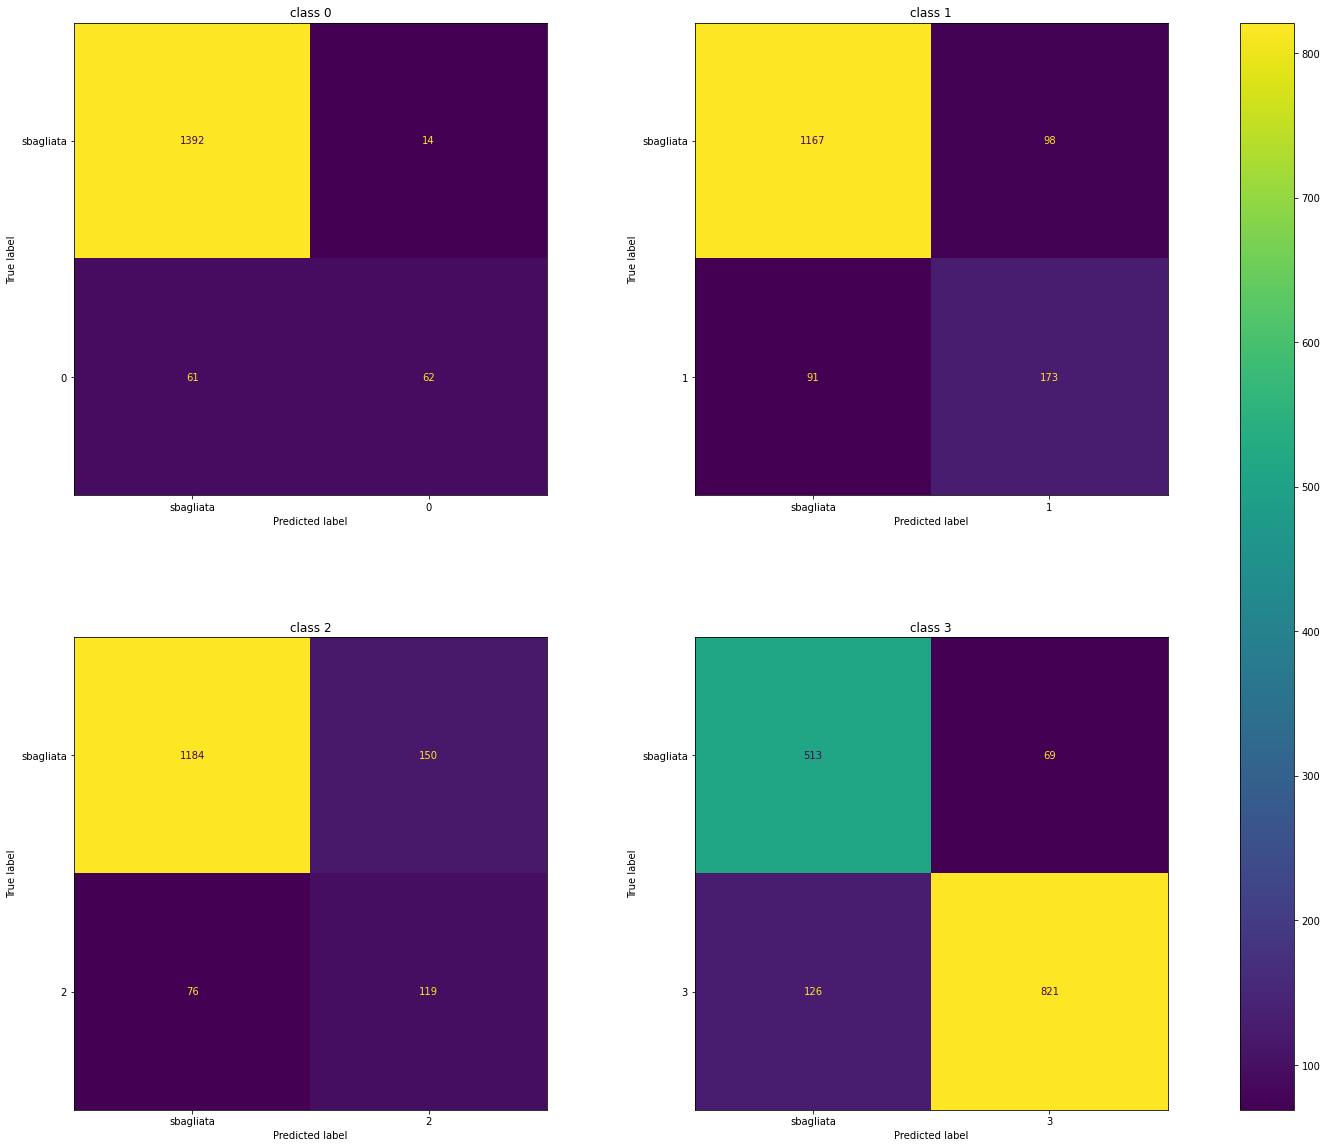

In [ ]:
conf_matrix_plot(y=y_val, y_pred_bool=y_val_pred_bool)

Le matrici di confusione ottenute con il validation set risultano essere molto simili a quelle ottenute precedentemente con gli altri modelli. Si può però notare una miglior predizione della classe 1.

In [ ]:
evaluation_metrics(X=X_val, y=y_val, y_pred=y_val_pred, model=best_l2_es_cw)

Loss: 1.2898025512695312
Accuracy: 0.7710922360420227

               precision    recall  f1-score   support

           0       0.50      0.82      0.62        76
           1       0.66      0.63      0.64       276
           2       0.62      0.43      0.51       284
           3       0.87      0.92      0.89       893

    accuracy                           0.77      1529
   macro avg       0.66      0.70      0.67      1529
weighted avg       0.77      0.77      0.76      1529



Loss e accuracy sul validation set sono simili a quelle ottenute con L2 e peggiori rispetto a quelle ottenute con L2 e Early Stopping.
In generale però i valori di precision e recall risultano migliori rispetto a quelli ottenuti precedentemente (anche se non di molto). La classe più debole rimane la 2.

### Test set performance

In [ ]:
y_test_pred, y_test_pred_bool, matrix = conf_matrix(X_test, y_test, model=best_l2_es_cw)

Confusion Matrix:


array([[[1715,   33],
        [  73,   91]],

       [[1460,  141],
        [ 128,  183]],

       [[1459,  199],
        [ 103,  151]],

       [[ 628,  101],
        [ 189,  994]]])

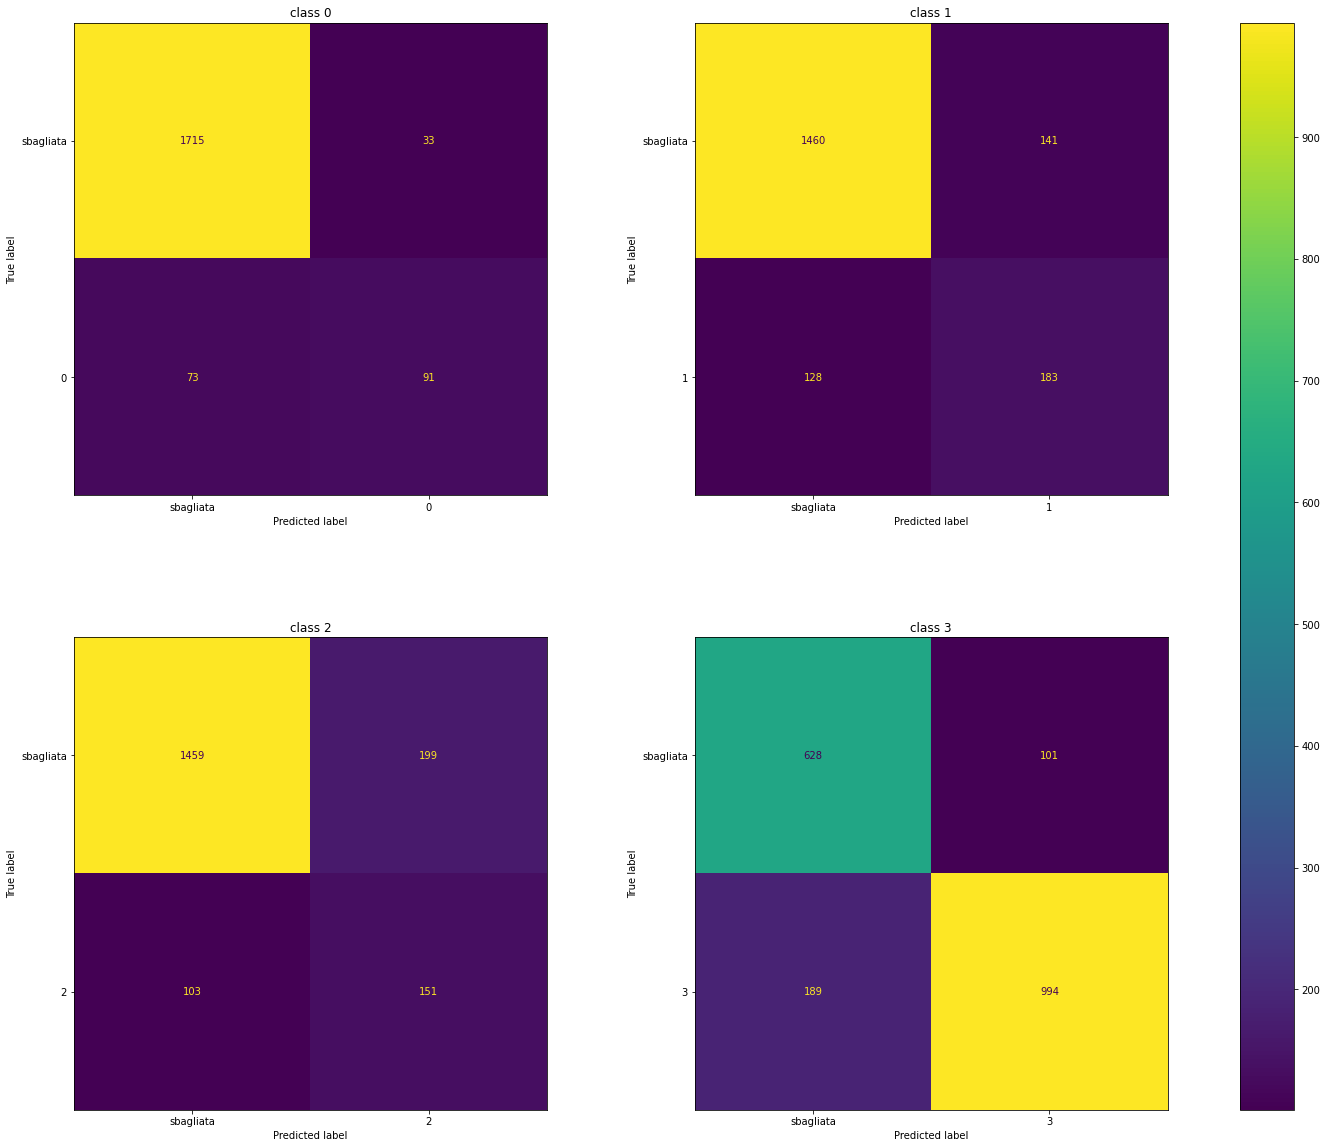

In [ ]:
conf_matrix_plot(y=y_test, y_pred_bool=y_test_pred_bool)

Al di là dei sempre buoni risultati ottenuti nella predizione della classe 3, notiamo che in questo caso si hanno molti falsi positivi nella classe 2.

In [ ]:
evaluation_metrics(X=X_test, y=y_test, y_pred=y_test_pred, model=best_l2_es_cw)

Loss: 1.5593527555465698
Accuracy: 0.7458158731460571

               precision    recall  f1-score   support

           0       0.55      0.73      0.63       124
           1       0.59      0.56      0.58       329
           2       0.60      0.42      0.50       359
           3       0.84      0.91      0.87      1100

    accuracy                           0.75      1912
   macro avg       0.65      0.66      0.65      1912
weighted avg       0.74      0.75      0.74      1912



Loss e accuracy calcolate sul test set risultano essere peggiori rispetto a quando calcolate sul validation set. Si riscontra inoltre un peggioramento nella predizione della classe 1.

In generale nessuno dei modelli osservati spicca fra gli altri, in quanto i risultati ottenuti risultano essere sempre molto simili fra loro.